# Setting GPU

In [1]:
import os

# PROJECT_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis"
# os.environ['PATH'] = "/sbin:/bin:/usr/bin:/usr/local/bin:/snap/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin"
# os.environ['PATH'] = PROJECT_FOLDER+"/miniconda3/bin:" + os.environ['PATH'] 
os.environ['PATH'] 

'/data/students_home/amoscatelli/.local/bin:/data/students_home/amoscatelli/Desktop/actionAnalysis/miniconda3/bin:/data/students_home/amoscatelli/Desktop/actionAnalysis/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/usr/local/cuda/bin:/snap/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin'

In [2]:
import os
# with tf.device("/GPU:0"):
# os.environ["CUDA_VISIBLE_DEVICES"]="1,2"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

## (Almost) Reproducible results

In [3]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=32, inter_op_parallelism_threads=32)
# session_conf = tf.ConfigProto()
session_conf.gpu_options.allow_growth = True

from keras import backend as K

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/student

In [4]:
# import tensorflow as tf
# tf.test.is_built_with_cuda()

In [5]:
# from keras import backend as K
# import tensorflow as tf
# # import os
# # with tf.device("/GPU:0"):
# # os.environ["CUDA_VISIBLE_DEVICES"]="0"
# K.tensorflow_backend._get_available_gpus()

In [6]:
# import tensorflow as tf
# from tensorflow.python.client import device_lib
# # gpus = tf.config.experimental.list_physical_devices('GPU')
# # tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
# device_lib.list_local_devices()

In [7]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# # config.log_device_placement = True  # to log device placement (on which device the operation ran)
#                                     # (nothing gets printed in Jupyter, only if you run it standalone)
# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

# Setting for training

In [8]:
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"

In [9]:
import keras
keras.__version__

'2.3.1'

## Load Dataset and count zero's

In [10]:
import numpy as np
import pickle
def getData(datasetName):
    with open(datasetName,'rb') as file_in:
#         features, labels, setups, cameras, performers, replications = pickle.load(file_in)
        train_set, val_set, test_set = pickle.load(file_in)
    
    #### stats ################################
    labels = ["train_set", "val_set", "test_set"]
    for i,dataset in enumerate([train_set, val_set, test_set]):
        totalsize, zero_elements =  getZeroStatsForDataset(dataset[0])
        print("{} shape: {}".format(labels[i], dataset[0].shape))
        print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))
        
    return train_set, val_set, test_set

def getZeroStatsForDataset(X):
    totalsize = sum([len(x)*len(x[0])*2 for x in X])
    non_zero_elements = sum([np.count_nonzero(x) for x in X])
    zero_elements = totalsize - non_zero_elements
    return totalsize, zero_elements

## Data preprocessing functions

In [11]:
# it removes the zeros from the dataset features taking for each video the closest non-zero value 
def removeZerosFromDataset(X):
    print("removing zeros from dataset")
    for i,video in enumerate(X):
        if sum([np.count_nonzero(frame==0) for frame in video])>0:
#             print("removing zeros from video", i)
            removeZerosFromVideo(video)
    return X
    
# return the closest non zero point for the passed point
def getClosestNonZeroCoordinate(frameIdx, point, features):
    for hop in range(1,len(features)):
        previousIdx = max(0, frameIdx-hop)
        nextIdx = min(len(features)-1, frameIdx+hop)
        if all(features[previousIdx][point] != 0):
            return features[previousIdx][point]
        if all(features[nextIdx][point] != 0):
            return features[nextIdx][point]
    return [0.0,0.0] #in case that point is never found in the video
        
# it removes the zeros from the video features taking the closest non-zero values for each point
def removeZerosFromVideo(videoFeatures):
    # retrieving the index of the points which contain 0 values for each frame 
    zeroPoints = [list(set(np.where(frame == 0.)[0])) for frame in videoFeatures] 
    
    # concatenating the previous result with the frame index (discarding correct frames)
    zeroPointsCoordinates = [(i,p) for i,p in enumerate(zeroPoints) if len(p)>0]
    
    oldVideo = np.copy(videoFeatures)
    notFoundPoints = set()
    for frameIdx, pointCoordinates in zeroPointsCoordinates:
        for pointIdx in pointCoordinates:
            if pointIdx in notFoundPoints:
                videoFeatures[frameIdx][pointIdx] = [0.0,0.0]
            else:
                videoFeatures[frameIdx][pointIdx] = getClosestNonZeroCoordinate(frameIdx, pointIdx,oldVideo)
            
            if np.count_nonzero(videoFeatures[frameIdx][pointIdx]) == 0:
                notFoundPoints.add(pointIdx)

In [12]:
from sklearn.preprocessing import LabelBinarizer
def one_hot_encoding(labels):
    encoder = LabelBinarizer()
    label_strings = [str(i) for i in labels]
    oneHotLabels = encoder.fit_transform(label_strings)
    print('classes order:', encoder.classes_) 
    return oneHotLabels, encoder.classes_
    
from keras.preprocessing.sequence import pad_sequences

def paddingTrainValTest(X_train, X_val, X_test, maxLength=None):
    if maxLength is None:
         maxLength = max([len(s) for s in np.concatenate((X_train, X_val, X_test), axis=0)])
    
    # 17 if there is always only 1 person, 34 if there are videos with 2 people
    maxVideoHeigth = max([len(s[0]) for s in np.concatenate((X_train, X_val, X_test), axis=0)])
    
    for dataset in [X_train, X_val, X_test]:
        for i in range(len(dataset)):
            if dataset[i].shape[1] < maxVideoHeigth:
                videoShape = dataset[i].shape
                missingPart = (videoShape[0], maxVideoHeigth-videoShape[1], videoShape[2])
#                 dataset[i] = np.concatenate((dataset[i],np.zeros(dataset[i].shape)),axis=1)
                dataset[i] = np.concatenate((dataset[i], np.zeros(missingPart)), axis=1)
    
    
    X_train = pad_sequences(X_train, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    X_val = pad_sequences(X_val, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    X_test = pad_sequences(X_test, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    
    ### stats ######################################
    labels = ["train set", "val set", "test set"]
    for i, dataset in enumerate([X_train, X_val, X_test]):
        totalsize, zero_elements =  getZeroStatsForDataset(dataset)
        print("{} shape: {}".format(labels[i], dataset.shape))
        print("{} zero elements (after padding): {} ({:.2f}%)".format(labels[i],zero_elements,zero_elements*100/totalsize))
    
    return X_train, X_val, X_test

In [13]:
# def normaliseBeforePadding(X_train, X_val, X_test):
#     print("!!!! That's not correct. It normalize the datasets all in one. You should normalize each video indipendently.")
#     trainAndVal = np.concatenate((X_train, X_val), axis=0)
#     print("normalising train, val and test values BEFORE padding")
#     trainMean = np.vstack(trainAndVal).mean() # the mean and std must be calculated only on the training data
#     trainStd = np.vstack(trainAndVal).std()
#     normalized_X_train = np.array([(x - trainMean)/trainStd for x in X_train])
#     normalized_X_val = np.array([(x - trainMean)/trainStd for x in X_val])
#     normalized_X_test = np.array([(x - trainMean)/trainStd for x in X_test])

#     return normalized_X_train, normalized_X_val, normalized_X_test

In [14]:
def normalizeVideosXYInpid(dataset):
    print("normalising EACH VIDEO, considering x and y INDIPENDENTLY")

    for i in range(len(dataset)):
        xAndYVideoMean = np.mean(np.vstack(dataset[i]),axis=0)
        xAndYVideoStd = np.std(np.vstack(dataset[i]),axis=0)
        dataset[i] = (dataset[i]-xAndYVideoMean)/xAndYVideoStd

    return dataset

In [15]:
def normalizeVideos(dataset):
    print("normalising EACH VIDEO, considering x and y TOGETHER")
    for i in range(len(dataset)):
        videoMean = np.mean(np.vstack(dataset[i]))
        videoStd = np.std(np.vstack(dataset[i]))
        dataset[i] = (dataset[i]-videoMean)/videoStd

    return dataset

In [16]:
# Posenet predicts:
# 1 - nose             18
# 2 - leftEye          19
# 3 - rightEye         20
# 4 - leftEar          21
# 5 - rightEar         22

# 6 - leftShoulder     23
# 7 - rightShoulder    24
# 8 - leftElbow        25
# 9 - rightElbow       26
# 10 - leftWrist       27
# 11 - rightWrist      28

# 12 - leftHip         29
# 13 - rightHip        30
# 14 - leftKnee        31
# 15 - rightKnee       32
# 16 - leftAnkle       33
# 17 - rightAnkle      34

In [17]:
def relativeToVideoCenter(X):
    print("Adapting the data to the CENTER of each VIDEO")
    for i,frames in enumerate(X):
        # calculating the center of the whole video
        videoMean = np.mean([np.mean(features,axis=0) for features in frames], axis = 0) 
        X[i] = [frame-videoMean for frame in frames]

    return X

def relativeToPersonVideoCenter(X):
    print("Adapting the data to the video PERSON CENTER of each VIDEO")
    for i,frames in enumerate(X):
        # calculating the center of the frames points relative to the whole video
        videoMean = np.mean([np.mean(features[:17],axis=0) for features in frames], axis = 0) 

        if len(frames[0]) == 34:
            videoMean2 = np.mean([np.mean(features[17:],axis=0) for features in frames], axis = 0) 
            videoMean = np.vstack((videoMean, videoMean2)) 
            videoMean = np.repeat(videoMean, [17, 17], axis=0)
        
        X[i] = [frame-videoMean for frame in frames]

    return X

In [18]:
def relativeToFrameCenter(X):
    print("Adapting the data to the CENTER of each FRAME")
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            frame_mean = np.mean(frame,axis=0)
            X[i_video][i_frame] = frame - frame_mean

    return X

def relativeToPersonFrameCenter(X):
    print("Adapting the data to the PERSON CENTER of each FRAME")
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            frame_mean = np.mean(frame[:17],axis=0)
            if len(frame) == 34:
                frame_mean2 = np.mean(frame[17:],axis=0)
                frame_mean = np.vstack((frame_mean, frame_mean2)) 
                frame_mean = np.repeat(frame_mean, [17, 17], axis=0)
            X[i_video][i_frame] = frame - frame_mean

    return X

In [19]:
def relativeTo5BaricentersNTURGBofVideo(X):
    print("Adapting the data to the 5 body baricenters of each video as in NTU-RGB-60")
    for i_video,frames in enumerate(X): 
        troncoPoints = [0,1,2,3,4,5,6,11,12]
        rightArmPoints = [8,10]
        leftArmPoints = [7,9]
        rightLegPoints = [14,16]
        leftLegPoints = [13,15] 
        videoCenterFrame = np.zeros(frames[0].shape)
        for person_offset in range(0,len(frames[0]),17):
            troncoPoints = [i+person_offset for i in troncoPoints]
            rightArmPoints += [i+person_offset for i in rightArmPoints]
            leftArmPoints += [i+person_offset for i in leftArmPoints]
            rightLegPoints += [i+person_offset for i in rightLegPoints]
            leftLegPoints += [i+person_offset for i in leftLegPoints]
            troncoCenter = np.mean(np.mean(np.array(frames)[:,troncoPoints], axis=1),axis=0)
            rightArmCenter = np.mean(np.mean(np.array(frames)[:,rightArmPoints], axis=1),axis=0)
            leftArmCenter = np.mean(np.mean(np.array(frames)[:,leftArmPoints], axis=1),axis=0)
            rightLegCenter = np.mean(np.mean(np.array(frames)[:,rightLegPoints], axis=1),axis=0)
            leftLegCenter = np.mean(np.mean(np.array(frames)[:,leftLegPoints], axis=1),axis=0)

#             videoCenterFrame = np.array(frames[0],dtype=np.float)
            videoCenterFrame[troncoPoints] = troncoCenter 
            videoCenterFrame[rightArmPoints] = rightArmCenter 
            videoCenterFrame[leftArmPoints] = leftArmCenter 
            videoCenterFrame[rightLegPoints] = rightLegCenter 
            videoCenterFrame[leftLegPoints] = leftLegCenter 

        X[i_video] = frames - videoCenterFrame
    return X

def relativeTo5BaricentersNTURGBofVideoAbs(X):
    return abs(relativeTo5BaricentersNTURGBofVideo(X))

In [20]:
# # model_name = "keypoint_rcnn_X_101_32x8d_FPN_3x"
# model_name = "PoseNet-101"
# datasetName = DATASET_FOLDER+model_name+"-CROSS_SUBJECT_TEST-dataset.pickle"

# train_set, val_set, test_set = getData(datasetName)

# train_set[0] = removeZerosFromDataset(train_set[0])
# val_set[0] = removeZerosFromDataset(val_set[0])
# test_set[0] = removeZerosFromDataset(test_set[0])

# labels = ["train_set", "val_set", "test_set"]
# for i,dataset in enumerate([train_set, val_set, test_set]):
#     totalsize, zero_elements =  getZeroStatsForDataset(dataset[0])
#     print("{} shape: {}".format(labels[i], dataset[0].shape))
#     print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))

    
# X_to_test = train_set[0][0]
# X_to_test = X_to_test[:2]
# X_to_test = np.expand_dims(X_to_test, axis=0)
# print("X_to_test shape", X_to_test.shape)

In [21]:
# def relativeTo3BaricentersOfFrame(X):
#     assert False, "Va testato"
#     print("Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame")
#     for i_video, video in enumerate(X):
#         for i_frame, frame in enumerate(video):
#             X[i_video][i_frame][:5] = frame[:5] - np.mean(frame[:5], axis=0)
#             X[i_video][i_frame][5:11] = frame[5:11] - np.mean(frame[5:11], axis=0)
#             X[i_video][i_frame][11:17] = frame[11:17] - np.mean(frame[11:17], axis=0)
#             if len(frame) == 34:
#                 X[i_video][i_frame][17:22] = frame[17:22] - np.mean(frame[17:22], axis=0)
#                 X[i_video][i_frame][22:28] = frame[22:28] - np.mean(frame[22:28], axis=0)
#                 X[i_video][i_frame][28:34] = frame[28:34] - np.mean(frame[28:34], axis=0)
#     return X

In [22]:
def relativeTo3BaricentersOfVideo(X):
    print("Adapting the data to the 3 BARICENTERS of each VIDEO")
    
    for i_video,frames in enumerate(X):        
        videoUpperMeanP1 = np.mean([np.mean(features[:5], axis=0) for features in frames], axis = 0) 
        videoMiddleMeanP1 = np.mean([np.mean(features[5:11], axis=0) for features in frames], axis = 0) 
        videoBottomMeanP1 = np.mean([np.mean(features[11:17], axis=0) for features in frames], axis = 0) 
        if len(frames[0]) == 34:
            videoUpperMeanP2 = np.mean([np.mean(features[17:22], axis=0) for features in frames], axis = 0) 
            videoMiddleMeanP2 = np.mean([np.mean(features[22:28], axis=0) for features in frames], axis = 0) 
            videoBottomMeanP2 = np.mean([np.mean(features[28:34], axis=0) for features in frames], axis = 0) 
        
        for i_frame, frame in enumerate(frames):
            X[i_video][i_frame][:5] = frame[:5] - videoUpperMeanP1
            X[i_video][i_frame][5:11] = frame[5:11] - videoMiddleMeanP1
            X[i_video][i_frame][11:17] = frame[11:17] - videoBottomMeanP1
            if len(frame) == 34:
                X[i_video][i_frame][17:22] = frame[17:22] - videoUpperMeanP2
                X[i_video][i_frame][22:28] = frame[22:28] - videoMiddleMeanP2
                X[i_video][i_frame][28:34] = frame[28:34] - videoBottomMeanP2
                
    return X

def relativeTo3BaricentersOfVideoAbs(X):
    return abs(relativeTo3BaricentersOfVideo(X))

In [23]:
def relativeTo17BaricentersOfVideo(X):
    print("Adapting the data as the difference to the center of EACH KEYPOINT in the VIDEO")   
    for i_video,frames in enumerate(X): 
        video_mean_by_points = np.mean(X[i_video],axis=0)
        X[i_video] = X[i_video] - video_mean_by_points
    return X

def relativeTo17BaricentersOfVideoAbs(X):
    return abs(relativeTo17BaricentersOfVideo(X))

In [24]:
# def relativeToNextFrameOLD(X):
#     print("Adapting the data to the next frame")
#     newX = []
#     for frames in X:
#         motions = []
#         for i in range(len(frames)-1):
#             motions.append(np.array(frames[i+1])-np.array(frames[i]))
#         newX.append(motions)
#     return np.array(newX)

In [25]:
# builder function which return a function to calculate the difference each N frames
def relativeToNextFrameBuilder(step):
    step = step
    
    # it smooths the dataset following the Savitzky-Golay algorithm
    def relativeToNextFrame(X):
        print("Adapting the data to the next",step,"frame")
        newX = []
        for frames in X:
            # repeat the last frame of the video as much as the number of steps
            frames = np.concatenate((frames,np.repeat(np.expand_dims(frames[-1],axis=0),step,axis=0)))
            motions = np.array([frames[i+step]-frames[i] for i in range(len(frames)-step-1)])
            newX.append(motions)
        return np.array(newX)
    
    if step>1:
        relativeToNextFrame.__name__ = "relativeToNextFrame_"+str(step)
    return relativeToNextFrame
  

In [26]:
def cumulativeDifferences(X):
        print("Adapting the data as the CUMULATIVE DIFFERENCES of consecutive frames")
        newX = []
        for frames in X:
            motions = frames - frames[0]
            newX.append(motions)
        return np.array(newX)

In [27]:
import math
def euclDistance(point1,point2):
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def relativeToPointDistances(X):
    print("Adapting the data to the DISTANCES between points of each person in each FRAME")
    newX = []
    for videoIdx,video in enumerate(X):
        if videoIdx % 100 == 0:
            print("{}/{} video done".format(videoIdx,len(X)))
        
        videoDistances = np.zeros((len(video),len(video[0]),17))
        
        for fIdx, frame in enumerate(video):
            distances = [[euclDistance(frame[i],frame[j]) for j in range(17)] for i in range(17)]
            if len(frame) == 34:
                distancesP2 = [[euclDistance(frame[i],frame[j]) for j in range(17,34)] for i in range(17,34)]
                distances = np.concatenate((distances,distancesP2),axis = 0)
            videoDistances[fIdx] = distances
        
        newX.append(videoDistances)
    return np.array(newX)

In [28]:
# #ARTIFICIAL 
# # X_to_test = np.arange(2*2*17*2).reshape((2,2,17,2)) # 1 person
# X_to_test = np.arange(2*3*34*2).reshape((2,3,34,2)) # 2 people
# # X_to_test = X_to_test*0.3
# X_to_test
# # print(type(X_to_test[0][0][0][0]))

In [29]:
def preprocessData(train_set, val_set, test_set, preprocess_functions = None):
    X_train, X_val, X_test = train_set[0], val_set[0], test_set[0]
    # one hot encoding
    y_train, encoding_train = one_hot_encoding(train_set[1])
    y_val, encoding_val = one_hot_encoding(val_set[1])
    y_test, encoding_test = one_hot_encoding(test_set[1])
    
    assert all(encoding_train == encoding_val)
    assert all(encoding_val == encoding_test)

    # preprocess
    if preprocess_functions is not None:
        for preprocess_function in preprocess_functions:
            X_train = preprocess_function(X_train)
            X_val = preprocess_function(X_val)
            X_test = preprocess_function(X_test)

    #padding
    X_train, X_val, X_test = paddingTrainValTest(X_train, X_val, X_test)

    
    ## reshaping after padding ###
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2] * X_train.shape[3])
    X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2] * X_val.shape[3])
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2] * X_test.shape[3])
    
#     ## reshaping without padding ###
#     for dataset in [X_train, X_val, X_test]:
#         for i in range(len(dataset)):
#             dataset[i] = dataset[i].reshape(dataset[i].shape[0], 
#                                             dataset[i].shape[1] * dataset[i].shape[2])

    encoding_train = [int(i) for i in encoding_train]

    return X_train, y_train, X_val, y_val, X_test, y_test, encoding_train

In [30]:
import scipy
from scipy import signal

# builder function which returs a Savitzky-Golay smoother function with the passed arguments
def smoothingPoints(window, order):
    movingWindow = window
    polynomialOrder = order
    
    # it smooths the dataset following the Savitzky-Golay algorithm
    def smooth(X):
        for vidIdx, video in enumerate(X):
            if vidIdx % 500 == 0:
                print("smooting video {}/{}".format(vidIdx,len(X)))
            for p in range(len(X[0][0])): # X[0][0] == 17 or 34 -> the number of points
                x, y = zip(*[(f[p][0], f[p][1]) for f in video])
                
                #     Savitzky-Golay
                smooth_x = signal.savgol_filter(x, movingWindow, polynomialOrder)
                smooth_y = signal.savgol_filter(y, movingWindow, polynomialOrder)
                
                # placing the smoothed series
                for i,frame in enumerate(video):
                    frame[p] = [smooth_x[i], smooth_y[i]]
        return X
    
    smooth.__name__ = "smooth_"+str(window)+"_"+str(order)
        
    return smooth

# Setting data

In [31]:
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"

# DATASET_FOLDER = "/content/gdrive/My Drive/actionAnalysis/datasets/"
# SAVED_MODEL_FOLDER = "/content/gdrive/My Drive/actionAnalysis/savedModels/"
      
folder_where_save1 = "Cross_subject/"
folder_where_save2 = "Cross_view/"        

# folder_where_save1 = "Cross_view_lrScan/"        
# folder_where_save1 = "Cross_subject_lrScan/"     
# folder_where_save2 = "Cross_subject_lrScan/"
# SCAN_EPOCHS = 10

# folder_where_save1 = "Cross_view_tough/" 
# folder_where_save2 = "Cross_view_tough/" 

# folder_where_save1 = "Cross_subject_tough/"
# folder_where_save2 = "Cross_view_tough/"

# folder_where_save1 = "Cross_view_test/" 
# folder_where_save2 = "Cross_subject_test/"

# folder_where_save1 = "Cross_view_mini/"     
# folder_where_save2 = "Cross_subject_mini/"  

# folder_where_save1 = "Senesi/"
# folder_where_save2 = "Cross_subject/"

# folder_where_save1 = "Cross_view/"
# folder_where_save2 = "top-models/"


MODEL_NAME_VALUES = [
#     "keypoint_rcnn_X_101_32x8d_FPN_3x"
    "PoseNet-101"
    ]

# 85,14	89,39 (87,18)	80,88 (90,00)	det-3L-rimoz_0-3BAR-norm-drop-0,05-rec_drop-0,05
# 84,92	90,33 (86,43)	79,51 (90,20)	det-4L-cuda-rimoz_0-3BAR-norm-drop-0,1
# 84,72	90,36 (86,38)	79,08 (90,33)	det-4L-cuda-rimoz_0-3BAR-norm-drop-0,15

# 81,74   86,31 (82,94)   77,17 (86,01)   det-3L-cuda-HU_64-LR_0,015-OFF_0,002-POW_1,5-rimoz_0-3BAR-norm-drop-0,1-reg-1e-06
# 81,67   84,99 (82,08)   78,35 (86,82)   det-3L-cuda-HU_64-LR_0,015-OFF_0,002-POW_1,5-rimoz_0-3BAR-norm-drop-0,05-reg-1e-06
# 81,57   86,29 (83,70)   76,85 (84,08)   det-3L-cuda-HU_64-LR_0,02-OFF_0,002-POW_1,5-rimoz_0-3BAR-norm-drop-0,15-reg-1e-05

PATIENCE = 100
HIDDEN_UNITS_VALUES = [64]

#                         [0.04,0.039,0.038,0.037,0.036,0.035,0.034,0.033,0.032,0.031,
#                         0.03,0.029,0.028,0.027,0.026,0.025,0.024,0.023,0.022,0.021,
#                         0.02,0.019,0.018,0.017,0.016,0.015,0.014,0.013,0.012,0.011,
#                         0.01,0.009,0.008,0.007,0.006,0.005,0.004,0.003,0.002,0.001]
BATCH_SIZE = 600
REFERENCE_EPOCHS = 100 #the earlystop will eventually stop the training
EPOCHS = 100

USE_SCHEDULER = True
LEARNING_RATE_VALUES = [0.02]
###### STEP SCHEDULER ###################
# def stepScheduler(epoch, lr):
#     DECAY_RATE = 0.8
#     DECAY_STEP = 15
#     if epoch % DECAY_STEP == 0 and epoch:
#         return lr * DECAY_RATE
#     return lr
# scheduler = stepScheduler
##########################################

###### LINEAR SCHEDULER ###################
# def linearScheduler(epoch, lr):
#     return max(lr - LEARNING_RATE/EPOCHS,0)
# scheduler = linearScheduler
##########################################

###### POLYNOMIAL SCHEDULER #############
LR_OFFSET = 0.002
LR_POWER = 1.5
def polynomialScheduler(epoch, lr):
    if epoch < REFERENCE_EPOCHS:
        decay = (1 - (epoch / float(REFERENCE_EPOCHS)))  ** LR_POWER
        alpha = LEARNING_RATE * decay
        return float(alpha)+LR_OFFSET
    else:
        return LR_OFFSET
scheduler = polynomialScheduler
##########################################

USE_LSTM = False
USE_CuDNNLSTM = not USE_LSTM

REGULARIZER_VALUES = [0,
                      0.00001,
                      0.000001,
                      0.0001]  

DROPOUT_VALUES = [0, 0.05, 0.1,0.15, 0.2] # [] == don't load

LOAD_FROM_PREVIOUS_DROPOUT = [] # [] == don't load

LSTM_LAYERS_VALUES = [2]
PREPROCESS_FUNCTION_TO_TEST = [
    
     (folder_where_save1,[removeZerosFromDataset,relativeTo3BaricentersOfVideo,normalizeVideos])
     ,(folder_where_save2,[removeZerosFromDataset,relativeTo3BaricentersOfVideo,normalizeVideos])
    
     ,(folder_where_save1,[removeZerosFromDataset,relativeTo3BaricentersOfVideoAbs,normalizeVideos])
     ,(folder_where_save2,[removeZerosFromDataset,relativeTo3BaricentersOfVideoAbs,normalizeVideos])
    
     ,(folder_where_save1,[removeZerosFromDataset,relativeToFrameCenter,normalizeVideos])
     ,(folder_where_save2,[removeZerosFromDataset,relativeToFrameCenter,normalizeVideos])
    
     ,(folder_where_save1,[removeZerosFromDataset,relativeToPersonFrameCenter,normalizeVideos])
     ,(folder_where_save2,[removeZerosFromDataset,relativeToPersonFrameCenter,normalizeVideos])
    
     ,(folder_where_save1,[removeZerosFromDataset,relativeToVideoCenter,normalizeVideos])
     ,(folder_where_save2,[removeZerosFromDataset,relativeToVideoCenter,normalizeVideos])
    
     ,(folder_where_save1,[removeZerosFromDataset,relativeToPersonVideoCenter,normalizeVideos])
     ,(folder_where_save2,[removeZerosFromDataset,relativeToPersonVideoCenter,normalizeVideos])
    
     ,(folder_where_save1,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideo,normalizeVideos])
     ,(folder_where_save2,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideo,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToPointDistances,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToPointDistances,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,cumulativeDifferences,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,cumulativeDifferences,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideoAbs,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideoAbs,normalizeVideos])
    
#      ,(folder_where_save1,[])
#      ,(folder_where_save2,[])
#      ,(folder_where_save1,[normalizeVideos])
#      ,(folder_where_save2,[normalizeVideos])
#      ,(folder_where_save1,[normalizeVideosXYInpid])
#      ,(folder_where_save2,[normalizeVideosXYInpid])
#      ,(folder_where_save1,[removeZerosFromDataset,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,normalizeVideos])
#      ,(folder_where_save1,[removeZerosFromDataset,normalizeVideosXYInpid])
#      ,(folder_where_save2,[removeZerosFromDataset,normalizeVideosXYInpid])

    
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo17BaricentersOfVideo,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo17BaricentersOfVideo,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo17BaricentersOfVideoAbs,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo17BaricentersOfVideoAbs,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(1),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(1),normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(3),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(3),normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(7),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(7),normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(15),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(15),normalizeVideos])
    
     
    # TECNIQUES

# relativeToVideoCenter
# relativeToPersonVideoCenter
# relativeToFrameCenter
# relativeToPersonFrameCenter
# relativeTo5BaricentersNTURGBofVideo
# relativeTo5BaricentersNTURGBofVideoAbs
# relativeTo3BaricentersOfVideo
# relativeTo3BaricentersOfVideoAbs
# relativeTo17BaricentersOfVideo
# relativeTo17BaricentersOfVideoAbs
# relativeToNextFrameBuilder(1)
# relativeToNextFrameBuilder(3)
# relativeToNextFrameBuilder(7)
# relativeToNextFrameBuilder(15)
# cumulativeDifferences
# relativeToPointDistances
]

if USE_LSTM:
    REGULARIZER_VALUES = [0]
if not USE_SCHEDULER:
    LR_OFFSET = 0
    LR_POWER = 0
 
    

print("NORMAL LSTM" if USE_LSTM else "CuDNNLSTM")
print(len(MODEL_NAME_VALUES),"MODEL_NAME_VALUES:", MODEL_NAME_VALUES)
print(len(LSTM_LAYERS_VALUES),"LSTM_LAYERS_VALUES LAYERS:", LSTM_LAYERS_VALUES)
print(len(HIDDEN_UNITS_VALUES), "HIDDEN UNITS",HIDDEN_UNITS_VALUES)
print(len(REGULARIZER_VALUES),"REGULARIZER_VALUES",REGULARIZER_VALUES)
print(len(DROPOUT_VALUES),"DROPOUT_VALUES",DROPOUT_VALUES)
print(len(PREPROCESS_FUNCTION_TO_TEST),"PREPROCESS_FUNCTION_TO_TEST")


numberOfTests = len(MODEL_NAME_VALUES)* len(LEARNING_RATE_VALUES)*len(HIDDEN_UNITS_VALUES) * len(PREPROCESS_FUNCTION_TO_TEST)*len(DROPOUT_VALUES)*len(REGULARIZER_VALUES)*len(LSTM_LAYERS_VALUES)
print()
print(len(LEARNING_RATE_VALUES),"LEARNING_RATE_VALUES",LEARNING_RATE_VALUES)
if USE_SCHEDULER:
#     print("\nUSE_SCHEDULER\n\tDECAY_RATE:", DECAY_RATE, "\n\tDECAY_STEP:", DECAY_STEP)
    print(scheduler.__name__)
    print("LR_OFFSET:",LR_OFFSET)
    print("LR_POWER:",LR_POWER)
print("\nNumber of tests:", numberOfTests)
print("PATIENCE:", PATIENCE)
print("BATCH_SIZE:", BATCH_SIZE)
print("REFERENCE_EPOCHS:", REFERENCE_EPOCHS)

SAVED_MODEL_FOLDER, folder_where_save1, folder_where_save2

CuDNNLSTM
1 MODEL_NAME_VALUES: ['PoseNet-101']
1 LSTM_LAYERS_VALUES LAYERS: [2]
1 HIDDEN UNITS [64]
4 REGULARIZER_VALUES [0, 1e-05, 1e-06, 0.0001]
5 DROPOUT_VALUES [0, 0.05, 0.1, 0.15, 0.2]
14 PREPROCESS_FUNCTION_TO_TEST

1 LEARNING_RATE_VALUES [0.02]
polynomialScheduler
LR_OFFSET: 0.002
LR_POWER: 1.5

Number of tests: 280
PATIENCE: 100
BATCH_SIZE: 600
REFERENCE_EPOCHS: 100


('/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/',
 'Cross_subject/',
 'Cross_view/')

## sequential trainings

In [32]:
def getSaveFileName(modelName,preprocess_functions,learning_rate, offset, power, numberOfLSTMLayers, useCudaLSTM, hiddenUnits, regularizerValue, dropOut, recurrentDropOut):
    saveFileName = modelName+"-{}L".format(numberOfLSTMLayers+1)
    saveFileName += "-CuDNNLSTM" if useCudaLSTM else ""
    saveFileName += "-HU_"+str(hiddenUnits)
    saveFileName += "-LR_"+str(learning_rate)
    saveFileName += "-OFF_"+str(offset)
    saveFileName += "-POW_"+str(power)
    if preprocess_functions is not None:
        for function in preprocess_functions:
            saveFileName += "-{}".format(function.__name__) 
                
    saveFileName += "-drop-"+str(dropOut)
    
    if useCudaLSTM:
        saveFileName += "-reg-"+str(regularizerValue)
    else:
        saveFileName += "-rec_drop-"+str(recurrentDropOut)
    
    return saveFileName

In [33]:
from sklearn.metrics import accuracy_score
def getValTestAccuracy(model,x_val,y_val,x_test,y_test, label_order = None):
    if label_order is None:
        raise Exception("define label order for val test accuracy evaluation")
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    return val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred

In [1]:
def cleanForExcel(text):
    replacements = (
        ("relativeToVideoCenter","VIDEO"),
        ("relativeToPersonVideoCenter","VIDEO_PERS"),        
        ("relativeToFrameCenter","FRAME"),        
        ("relativeToPersonFrameCenter","FRAME_PERS"),  
        ("relativeTo3BaricentersOfVideo","3BAR"),
        ("relativeToUpperMiddleBottomCentersOfVideo","3BAR"),        
        ("relativeTo5BaricentersNTURGBofVideo","5BAR"),
        ("relativeTo17BaricentersOfVideo","17BAR"),
        ("relativeToPointDistances","DIST_REL"),
        ("relativeToNextFrame","NEXT"),
        ("cumulativeDifferences","DIST_CUM"),
        ("removeZerosFromDataset","rimoz_0"), 
        ("normalizeVideosXYInpid","normXY"),
        ("normalizeVideos","norm"),     
        ("Abs","_ASS"),    
        ("CuDNNLSTM","cuda"),
        (".pickle",""),
        (".h5",""),
        (".",","),
        ("PoseNet-101","pos"),
        ("keypoint_rcnn_X_101_32x8d_FPN_3x","det"),
        ("-drop-0-","-"),
        ("-rec_drop-0-","-"),
        ("-reg-0#",""),
        ("-reg-0-","-"),
        ("#","")
    )
    text = text+"#"
    for r in replacements:
        text = text.replace(*r)
    return text


In [ ]:
import dill
from keras import models #, layers
from keras.layers import LSTM, CuDNNLSTM, Dropout, Dense #, Concatenate 
from keras.models import load_model #, Model
from keras.optimizers import RMSprop #Adam #, RMSprop, Adadelta
from keras.regularizers import l2 #, l1
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
from os import scandir
from os.path import exists, basename
import shutil 
import math
from numpy.random import seed
from tensorflow import set_random_seed 

import numpy as np
import tensorflow as tf
import random as rn
from keras import backend as K
import os


# earlyStop = EarlyStopping(monitor='val_acc', ## 4 COLAB 
earlyStop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=PATIENCE, 
                          verbose=1, 
                          mode='max', 
                          baseline=None, 
                          restore_best_weights=True)


progressCounter = 0
for MODEL_NAME in MODEL_NAME_VALUES:
    for LEARNING_RATE in LEARNING_RATE_VALUES:
        for LSTM_LAYERS in LSTM_LAYERS_VALUES:
            for regularizer_idx, regularizer in enumerate(REGULARIZER_VALUES):
                for dropOut_idx, dropOut in enumerate(DROPOUT_VALUES):
                    for HIDDEN_UNITS in HIDDEN_UNITS_VALUES:
                        
                        DROPOUT = dropOut
                        RECURRENT_DROPOUT = dropOut
#                         EPOCHS = round(REFERENCE_EPOCHS * (1+DROPOUT))

                        for i, (folder_where_to_save, preprocess_functions) in enumerate(PREPROCESS_FUNCTION_TO_TEST):
                            progressCounter += 1
                            folderPathWhereToSave = SAVED_MODEL_FOLDER+folder_where_to_save
                            if folder_where_to_save.endswith("_lrScan/"):
                                EPOCHS = SCAN_EPOCHS

                            alreadyTrainedModel = [f for f in scandir(folderPathWhereToSave) if f.path.endswith(".h5")]

                            ### SET SAVE FILE NAME ###
                            saveFileName = getSaveFileName(modelName = MODEL_NAME,
                                                           preprocess_functions = preprocess_functions,
                                                           learning_rate= LEARNING_RATE,
                                                           offset = LR_OFFSET,
                                                           power = LR_POWER,
                                                           numberOfLSTMLayers = LSTM_LAYERS,
                                                           useCudaLSTM = USE_CuDNNLSTM,
                                                           hiddenUnits = HIDDEN_UNITS,
                                                           regularizerValue = regularizer,
                                                           dropOut = DROPOUT, 
                                                           recurrentDropOut = RECURRENT_DROPOUT
                                                          )

                            print("######## {}/{} - {} - {} ########".format(progressCounter, numberOfTests, saveFileName, folder_where_to_save))

                            if saveFileName+".h5" in [m.name for m in alreadyTrainedModel]:
                                print("### already done! ####")
                                continue
                            else:
                                #to avoid that someone else will start the same fitting
                                print("touching",folderPathWhereToSave+saveFileName+".h5")
                                modelFileName = saveFileName+".h5"

        #                         pathToTouch = (folderPathWhereToSave+modelFileName).replace(" ","\ ") ## 4 COLAB 
                                modelFileNamePath = folderPathWhereToSave+modelFileName
                                !touch $modelFileNamePath
                                print("## To be saved in [...]{} ###".format(folderPathWhereToSave[54:]))

                            ### LOADING DATASET ###
                            if folderPathWhereToSave.endswith("Senesi/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-SENESI-dataset.pickle"
                            elif folderPathWhereToSave.endswith("top-models/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"      

                            elif folderPathWhereToSave.endswith("Cross_subject_test/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TEST-dataset.pickle"            
                            elif folderPathWhereToSave.endswith("Cross_view_test/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TEST-dataset.pickle"     

                            elif any([folderPathWhereToSave.endswith(s) for s in ["Cross_subject/","Cross_subject_lrScan/"]]):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT-dataset.pickle"       
                            elif any([folderPathWhereToSave.endswith(s) for s in ["Cross_view/","Cross_view_lrScan/"]]):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW-dataset.pickle"  

                            elif folderPathWhereToSave.endswith("Cross_view_tough/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TOUGH-dataset.pickle"            
                            elif folderPathWhereToSave.endswith("Cross_subject_tough/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TOUGH-dataset.pickle" 

                            elif folderPathWhereToSave.endswith("Cross_view_mini/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_MINI-dataset.pickle"            
                            elif folderPathWhereToSave.endswith("Cross_subject_mini/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_MINI-dataset.pickle"    

                            elif folderPathWhereToSave.endswith("top+Senesi_Cross_view/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TOP+SENESI-dataset.pickle"            
                            elif folderPathWhereToSave.endswith("top+Senesi_Cross_subject/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TOP+SENESI-dataset.pickle" 

                            elif folderPathWhereToSave.endswith("-SPLIT_DIFFERENT_FROM_DETECTRON-dataset)/") and MODEL_NAME == "PoseNet-101":
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT_DIFFERENT_FROM_DETECTRON-dataset.pickle"
                            else:
                                raise Exception("result folder not correct")

                            ### CHECK IF ALREADY PREPROCESSED DATASET EXISTS
                            preprocessed_datasetName = basename(datasetName).replace("-dataset.pickle","")
                            for f in preprocess_functions:
                                preprocessed_datasetName += "-"+f.__name__
                            preprocessed_datasetName += "-dataset.pickle"

                            preprocessed_datasetPath = DATASET_FOLDER+preprocessed_datasetName
                            
#                             print("###### NOT CHECKING IF THERE IS A PREPROCCED DATASET ######")
#                             if False:
                            if exists(preprocessed_datasetPath):
                                print("#### Loading preprocessed dataset: ", preprocessed_datasetPath)
                                with open(preprocessed_datasetPath,'rb') as file_in:
                                    prepDict = pickle.load(file_in)
                                    X_train = prepDict["X_train"]
                                    y_train = prepDict["y_train"]
                                    X_val = prepDict["X_val"]
                                    y_val = prepDict["y_val"]
                                    X_test = prepDict["X_test"]
                                    y_test = prepDict["y_test"]
                                    encodingLabels = prepDict["encodingLabels"]
                            else:
                                print("#### Loading dataset: ", datasetName)
                                train_set, val_set, test_set = getData(datasetName)
                                print("Preproccesing dataset...")
                                X_train, y_train, X_val, y_val, X_test, y_test, encodingLabels = preprocessData(train_set, 
                                                                                                               val_set, 
                                                                                                               test_set,  
                                                                                                               preprocess_functions)

#                             assert False, "stop here"
                            # TO SOLVE THE DROPOUT LAYER SHAPE PROBLEM
                            missing_train = (BATCH_SIZE-(X_train.shape[0]%BATCH_SIZE))%BATCH_SIZE
                            X_train = np.concatenate((X_train,X_train[:missing_train]),axis=0)
                            y_train = np.concatenate((y_train,y_train[:missing_train]),axis=0)

                            ### DEFINING MODEL ###
                            inputDim = (X_train.shape[1], X_train.shape[2])
                            outputLen = len(y_train[0])

                            ## callbacks and checkpoints
                            minLossModelName = "{}-min_val_loss.hdf5".format(folderPathWhereToSave+saveFileName)
                            checkpointLoss = ModelCheckpoint(minLossModelName, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

                            maxAccModelName = "{}-max_val_acc.hdf5".format(folderPathWhereToSave+saveFileName)

                            checkpointAcc = ModelCheckpoint(maxAccModelName, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 
        #                     checkpointAcc = ModelCheckpoint(maxAccModelName, monitor='val_acc', verbose=1, save_best_only=True, mode='max') ## 4 COLAB 


                            callbacks_list = [checkpointLoss, checkpointAcc]

                            if USE_SCHEDULER:
                                callbacks_list.append(LearningRateScheduler(scheduler, verbose=1))
                                callbacks_list.append(earlyStop)
                            else:
                                callbacks_list.append(earlyStop)


                            model = models.Sequential()
                            model.add(Dropout(DROPOUT, input_shape=inputDim, noise_shape=(BATCH_SIZE, 1, inputDim[1])))

                            if USE_LSTM:
                                if LSTM_LAYERS == 1:
                                    model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT))
                                else:       
                                    model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
                                    for layerIdx in range(2, LSTM_LAYERS):
                                        model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
                                    model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT))    

                            elif USE_CuDNNLSTM:
                                reg=l2(regularizer) if regularizer > 0 else None

                                if LSTM_LAYERS == 1:
                                    model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg))
                                else:
                                    model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg, return_sequences=True))
                                    for layerIdx in range(2, LSTM_LAYERS):
                                        model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg, return_sequences=True))                  
                                    model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer=reg))


                            model.add(Dense(outputLen, activation='softmax'))

#                             opt = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, amsgrad=False)
#                             opt = Adadelta(learning_rate=LEARNING_RATE, rho=0.95)
                            opt = RMSprop(lr=LEARNING_RATE, rho=0.9) ## 4 COLAB 
        #                     opt = RMSprop(lerning_rate=LEARNING_RATE, rho=0.9)

                            model.compile(
        #                                 optimizer='rmsprop',
                                        optimizer=opt,
                                        loss='categorical_crossentropy',
                                        metrics=['accuracy'])


                            ## RECOVER FROM MIN LOSS MODEL IF EXISTS
                            if exists(minLossModelName):
                                print("#### Loading weights from MIN LOSS model")
                                model.load_weights(minLossModelName)

                            ## RECOVER FROM MIN LOSS MODEL IF EXISTS
                            minLossBackupModelName = "{}-min_val_loss-BACKUP.hdf5".format(folderPathWhereToSave+saveFileName)
                            if exists(maxAccModelName):
                                print("#### Loading weights from MAX ACCURACY model")
                                model.load_weights(minLossModelName)
                                if exists(minLossModelName):
                                    print("#### BACKUP of weights for previous MIN LOSS model")
                                    shutil.copyfile(minLossModelName,minLossBackupModelName)

                            ## Loading weights from previous model trained with an higher dropout rate
                            loadedFromPreviousModel = False
                            if (DROPOUT > 0 or RECURRENT_DROPOUT > 0) and LOAD_FROM_PREVIOUS_DROPOUT and USE_LSTM:
                                for prev_dropOut in LOAD_FROM_PREVIOUS_DROPOUT:
                                    if prev_dropOut <= DROPOUT:
                                        continue
                                    previousModelName = getSaveFileName(modelName = MODEL_NAME, 
                                                                        preprocess_functions = preprocess_functions, 
                                                                        learning_rate= LEARNING_RATE,
                                                                        offset = LR_OFFSET,
                                                                        power = LR_POWER,
                                                                        numberOfLSTMLayers = LSTM_LAYERS, 
                                                                        useCudaLSTM = USE_CuDNNLSTM,
                                                                        hiddenUnits = HIDDEN_UNITS,
                                                                        regularizerValue = regularizer,
                                                                        dropOut = prev_dropOut, 
                                                                        recurrentDropOut = prev_dropOut)
                                    if exists(folderPathWhereToSave+previousModelName+".h5"):
                                        print("#### Loading weights from",previousModelName)
                                        model.load_weights(folderPathWhereToSave+previousModelName+".h5")
                                        loadedFromPreviousModel = True
                                        break


                            ## FIT ###    
                            model_history = model.fit(X_train, y_train,
                                                epochs=EPOCHS,
                                                batch_size=BATCH_SIZE,
                                                callbacks=callbacks_list,
                                                validation_data=(X_val, y_val)
                                               )

                            ### SAVE MODEL ###
                            model.save(folderPathWhereToSave+saveFileName+".h5")

                            ### SAVE HISTORY AND PREPROCESS FUNCTIONS ###
                            env_functions = [one_hot_encoding, 
                                              euclDistance,
                                              paddingTrainValTest, 
                                              getClosestNonZeroCoordinate,
                                              removeZerosFromVideo,
                                              getZeroStatsForDataset,
                                              preprocessData,
                                             ]

                            historyToSave = {
                                "acc" : model_history.history['accuracy'],
                                "val_acc" : model_history.history['val_accuracy'],
                                "loss" : model_history.history['loss'],
                                "val_loss" : model_history.history['val_loss']
                            }


                            info_to_save = {"history": historyToSave,
                                            "env_fun_DILL":[dill.dumps(x) for x in env_functions],
                                            "spec_fun_DILL":[dill.dumps(x) for x in preprocess_functions]}

                            if loadedFromPreviousModel:
                                info_to_save["loaded_from"] = previousModelName

                            with open(folderPathWhereToSave+saveFileName+".pickle","wb") as handle:
                                pickle.dump(info_to_save, handle) 
                                print("## Saved in {} ###\n\n".format(folderPathWhereToSave+saveFileName+".pickle"))


                            ### EVALUATING MODEL ### 
                            model = load_model(maxAccModelName)
                            !mv $maxAccModelName $modelFileNamePath
                            val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred = getValTestAccuracy(model,X_val,y_val,X_test,y_test, encodingLabels)
                            print("Model for MAX ACCURACY test_acc: {:.3f} val_acc: {:.3f}".format(test_acc*100,val_acc*100))

                            if exists(minLossModelName):
                                model_minLoss = load_model(minLossModelName)
                                val_acc_minLoss, test_acc_minLoss, y_val_true, y_val_pred_minLoss, y_test_true, y_test_pred_minLoss = getValTestAccuracy(model_minLoss,X_val,y_val,X_test,y_test,encodingLabels)
                                print("Model for MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss*100,val_acc_minLoss*100))
                            else:
                                print("Model for MIN LOSS NOT SAVED")
                                val_acc_minLoss = math.inf

                            if exists(minLossBackupModelName):
                                model_minLoss_b = load_model(minLossBackupModelName)
                                print("#### Evaluating BACKUP min loss model ####")
                                val_acc_minLoss_b, test_acc_minLoss_b, y_val_true, y_val_pred_minLoss_b, y_test_true, y_test_pred_minLoss_b = getValTestAccuracy(model_minLoss_b,X_val,y_val,X_test,y_test,encodingLabels)
                                print("Model for BACKUP MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss_b*100,val_acc_minLoss_b*100))
                                if (val_acc_minLoss_b < val_acc_minLoss):
                                    print("### keeping BACKUP MIN LOSS model ####")
                                    val_acc_minLoss, test_acc_minLoss, y_val_pred_minLoss, y_test_pred_minLoss = val_acc_minLoss_b, test_acc_minLoss_b, y_val_pred_minLoss_b, y_test_pred_minLoss_b
                                    !mv $minLossBackupModelName $minLossModelName
                                else:
                                    !rm $minLossBackupModelName

                            ### CLEANING MAX ACC CHECKPOINT 
                            ## 4 COLAB 
        #                     patToRemove = maxAccModelName.replace(" ","\ ")
    #                         patToRemove = maxAccModelName
    #                         !rm $patToRemove

                            ### SAVING RESULTS ###
                            if EPOCHS < 10:
                                print("## SKIPPING SAVING. EPOCHS < 11")
                                continue

                            if exists(folderPathWhereToSave+"summaryResults.pickle"):
                                print("Loading previous results...")
                                with open(folderPathWhereToSave+"summaryResults.pickle","rb") as handle:
                                        results = pickle.load(handle)
                            else:
                                results = []

                            results.append({"val_acc": val_acc, 
                                            "test_acc": test_acc, 
                                            "model_name": saveFileName, 
                                            "y_val_true": y_val_true,
                                            "y_val_pred": y_val_pred,
                                            "y_test_true": y_test_true,
                                            "y_test_pred": y_test_pred,

                                            "val_acc_minLoss": val_acc_minLoss, 
                                            "test_acc_minLoss": test_acc_minLoss, 
                                            "y_val_pred_minLoss": y_val_pred_minLoss,
                                            "y_test_pred_minLoss": y_test_pred_minLoss
                                           })

                            print("Dumping results...")
                            with open(folderPathWhereToSave+"summaryResults.pickle","wb") as handle:
                                pickle.dump(results, handle)

print("DONE!")


######## 1/280 - PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0 - Cross_subject/ ########
### already done! ####
######## 2/280 - PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0 - Cross_view/ ########
### already done! ####
######## 3/280 - PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideoAbs-normalizeVideos-drop-0-reg-0 - Cross_subject/ ########
### already done! ####
######## 4/280 - PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideoAbs-normalizeVideos-drop-0-reg-0 - Cross_view/ ########
### already done! ####
######## 5/280 - PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeToFrameCenter-normalizeVideos-drop-0-reg-0 - Cross_subject/ ########
### al

## To be saved in [...]/savedModels/Cross_subject/ ###
#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/PoseNet-101-CROSS_SUBJECT-dataset.pickle
train_set shape: (32256,)
train_set zero elements: 4070412/104805544 (3.9%)
val_set shape: (8064,)
val_set zero elements: 1067838/26143382 (4.1%)
test_set shape: (16560,)
test_set zero elements: 2234310/57232200 (3.9%)
Preproccesing dataset...
classes order: ['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '22'
 '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35' '36'
 '37' '38' '39' '4' '40' '41' '42' '43' '44' '45' '46' '47' '48' '49' '5'
 '50' '51' '52' '53' '54' '55' '56' '57' '58' '59' '6' '60' '7' '8' '9']
classes order: ['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '22'
 '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35' '36'
 '37' '38' '39' '4' '40' '41' '42' '43' '44' '45' '46' '47' '48' '49' '5'
 '50' '51' '52' '53' '54

## Continue Training

In [41]:
# "det-3L-cuda-HU_64-LR_0,017-OFF_0,001-POW_1,5-rimoz_0-3BAR-norm-drop-0,15"
MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
modelToContinueTrain = MODEL_NAME+"-3L-CuDNNLSTM-HU_64-LR_0.017-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0"
preprocess_functions = [removeZerosFromDataset,relativeTo3BaricentersOfVideo,normalizeVideos]

folderToTrain = "Cross_subject/"
CONFIGURATION_TO_CONTINUE_TRAIN = [(folderToTrain, modelToContinueTrain)]

PATIENCE = 100
EPOCHS = 50000
BATCH_SIZE = 600
        
LEARNING_RATE = 0.005
USE_SCHEDULER = False
###### POLYNOMIAL SCHEDULER #############
LR_OFFSET = 0.000
LR_POWER = 1
def polynomialScheduler(epoch, lr):
    decay = (1 - (epoch / float(EPOCHS)))  ** LR_POWER
    alpha = LEARNING_RATE * decay
    return float(alpha) + LR_OFFSET
scheduler = polynomialScheduler
##########################################




In [43]:
import dill
from keras import models #, layers
from keras.layers import LSTM, CuDNNLSTM, Dropout, Dense #, Concatenate 
from keras.models import load_model #, Model
from keras.optimizers import RMSprop
from keras.regularizers import l2 #, l1
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
from os import scandir
from os.path import exists, basename
import shutil 
import math
from numpy.random import seed
from tensorflow import set_random_seed 
import numpy as np
import tensorflow as tf
import random as rn
from keras import backend as K
import os


# earlyStop = EarlyStopping(monitor='val_acc', ## 4 COLAB 
earlyStop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=PATIENCE, 
                          verbose=1, 
                          mode='max', 
                          baseline=None, 
                          restore_best_weights=True)

for idx_configuration, (folderToTrain,modelToTrain) in enumerate(CONFIGURATION_TO_CONTINUE_TRAIN):
    print("######## {}/{} - {} - {} ########".format(idx_configuration, len(CONFIGURATION_TO_CONTINUE_TRAIN),cleanForExcel(modelToTrain),folderToTrain))

    folderPathWhereToSave = SAVED_MODEL_FOLDER+folderToTrain
    if not exists(folderPathWhereToSave+modelToTrain+".h5"):
        print("model {} not existend in folder {}".format(modelToTrain,folderToTrain))
        continue
          
    alreadyTrainedModel = [f for f in scandir(folderPathWhereToSave) if f.path.endswith(".h5")]
    
    saveFileName = modelToTrain+"-THEN_LR_"+str(LEARNING_RATE)
          
    if saveFileName+".h5" in [m.name for m in alreadyTrainedModel]:
        print("### already done! ####")
        continue
    else:
        #to avoid that someone else will start the same fitting
        print("touching",folderPathWhereToSave+saveFileName+".h5")
        modelFileName = saveFileName+".h5"

#       pathToTouch = (folderPathWhereToSave+modelFileName).replace(" ","\ ") ## 4 COLAB 
        modelFileNamePath = folderPathWhereToSave+modelFileName
        !touch $modelFileNamePath
        print("## To be saved in [...]{} ###".format(folderPathWhereToSave[54:]))

    ### LOADING DATASET ###
    if folderPathWhereToSave.endswith("Senesi/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-SENESI-dataset.pickle"
    elif folderPathWhereToSave.endswith("top-models/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"      

    elif folderPathWhereToSave.endswith("Cross_subject_test/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TEST-dataset.pickle"            
    elif folderPathWhereToSave.endswith("Cross_view_test/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TEST-dataset.pickle"     

    elif any([folderPathWhereToSave.endswith(s) for s in ["Cross_subject/","Cross_subject_lrScan/"]]):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT-dataset.pickle"       
    elif any([folderPathWhereToSave.endswith(s) for s in ["Cross_view/","Cross_view_lrScan/"]]):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW-dataset.pickle"  

    elif folderPathWhereToSave.endswith("Cross_view_tough/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TOUGH-dataset.pickle"            
    elif folderPathWhereToSave.endswith("Cross_subject_tough/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TOUGH-dataset.pickle" 

    elif folderPathWhereToSave.endswith("Cross_view_mini/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_MINI-dataset.pickle"            
    elif folderPathWhereToSave.endswith("Cross_subject_mini/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_MINI-dataset.pickle"    

    elif folderPathWhereToSave.endswith("top+Senesi_Cross_view/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TOP+SENESI-dataset.pickle"            
    elif folderPathWhereToSave.endswith("top+Senesi_Cross_subject/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TOP+SENESI-dataset.pickle" 

    elif folderPathWhereToSave.endswith("-SPLIT_DIFFERENT_FROM_DETECTRON-dataset)/") and MODEL_NAME == "PoseNet-101":
        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT_DIFFERENT_FROM_DETECTRON-dataset.pickle"
    else:
        raise Exception("result folder not correct")

    ### CHECK IF ALREADY PREPROCESSED DATASET EXISTS
    preprocessed_datasetName = basename(datasetName).replace("-dataset.pickle","")
    for f in preprocess_functions:
        preprocessed_datasetName += "-"+f.__name__
    preprocessed_datasetName += "-dataset.pickle"

    preprocessed_datasetPath = DATASET_FOLDER+preprocessed_datasetName

    if exists(preprocessed_datasetPath):
        print("#### Loading preprocessed dataset: ", preprocessed_datasetPath)
        with open(preprocessed_datasetPath,'rb') as file_in:
            prepDict = pickle.load(file_in)
            X_train = prepDict["X_train"]
            y_train = prepDict["y_train"]
            X_val = prepDict["X_val"]
            y_val = prepDict["y_val"]
            X_test = prepDict["X_test"]
            y_test = prepDict["y_test"]
            encodingLabels = prepDict["encodingLabels"]
    else:
        print("#### Loading dataset: ", datasetName)
        train_set, val_set, test_set = getData(datasetName)
        print("Preproccesing dataset...")
        X_train, y_train, X_val, y_val, X_test, y_test, encodingLabels = preprocessData(train_set, 
                                                                                       val_set, 
                                                                                       test_set,  
                                                                                       preprocess_functions)

    # TO SOLVE THE DROPOUT LAYER SHAPE PROBLEM
    missing_train = (BATCH_SIZE-(X_train.shape[0]%BATCH_SIZE))%BATCH_SIZE
    X_train = np.concatenate((X_train,X_train[:missing_train]),axis=0)
    y_train = np.concatenate((y_train,y_train[:missing_train]),axis=0)

    ### DEFINING MODEL ###
    inputDim = (X_train.shape[1], X_train.shape[2])
    outputLen = len(y_train[0])

    ## callbacks and checkpoints
    minLossModelName = "{}-min_val_loss.hdf5".format(folderPathWhereToSave+saveFileName)
    checkpointLoss = ModelCheckpoint(minLossModelName, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    maxAccModelName = "{}-max_val_acc.hdf5".format(folderPathWhereToSave+saveFileName)

    checkpointAcc = ModelCheckpoint(maxAccModelName, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 
#   checkpointAcc = ModelCheckpoint(maxAccModelName, monitor='val_acc', verbose=1, save_best_only=True, mode='max') ## 4 COLAB 


    callbacks_list = [checkpointLoss, checkpointAcc]

    if USE_SCHEDULER:
        callbacks_list.append(LearningRateScheduler(scheduler, verbose=1))
    else:
        callbacks_list.append(earlyStop)

            
    model = load_model(folderPathWhereToSave+modelToTrain+".h5")

    rmpsprop = RMSprop(lr=LEARNING_RATE, rho=0.9) 

    model.compile(
#               optimizer='rmsprop',
                optimizer=rmpsprop,
                loss='categorical_crossentropy',
                metrics=['accuracy'])


    ## RECOVER FROM MIN LOSS MODEL IF EXISTS
    if exists(minLossModelName):
        print("#### Loading weights from MIN LOSS model")
        model.load_weights(minLossModelName)

    ## RECOVER FROM MIN LOSS MODEL IF EXISTS
    minLossBackupModelName = "{}-min_val_loss-BACKUP.hdf5".format(folderPathWhereToSave+saveFileName)
    if exists(maxAccModelName):
        print("#### Loading weights from MAX ACCURACY model")
        model.load_weights(minLossModelName)
        if exists(minLossModelName):
            print("#### BACKUP of weights for previous MIN LOSS model")
            shutil.copyfile(minLossModelName,minLossBackupModelName)


    ## FIT ###    
    model_history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=callbacks_list,
                        validation_data=(X_val, y_val)
                       )

    ### SAVE MODEL ###
    model.save(folderPathWhereToSave+saveFileName+".h5")

    ### SAVE HISTORY AND PREPROCESS FUNCTIONS ###
    env_functions = [one_hot_encoding, 
                      euclDistance,
                      paddingTrainValTest, 
                      getClosestNonZeroCoordinate,
                      removeZerosFromVideo,
                      getZeroStatsForDataset,
                      preprocessData,
                     ]

    historyToSave = {
        "acc" : model_history.history['accuracy'],
        "val_acc" : model_history.history['val_accuracy'],
        "loss" : model_history.history['loss'],
        "val_loss" : model_history.history['val_loss']
    }


    info_to_save = {"history": historyToSave,
                    "env_fun_DILL":[dill.dumps(x) for x in env_functions],
                    "spec_fun_DILL":[dill.dumps(x) for x in preprocess_functions]}

    info_to_save["loaded_from"] = folderPathWhereToSave+modelToTrain

    with open(folderPathWhereToSave+saveFileName+".pickle","wb") as handle:
        pickle.dump(info_to_save, handle) 
        print("## Saved in {} ###\n\n".format(folderPathWhereToSave+saveFileName+".pickle"))


    ### EVALUATING MODEL ### 
    model = load_model(maxAccModelName)
    !mv $maxAccModelName $modelFileNamePath
    val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred = getValTestAccuracy(model,X_val,y_val,X_test,y_test, encodingLabels)
    print("Model for MAX ACCURACY test_acc: {:.3f} val_acc: {:.3f}".format(test_acc*100,val_acc*100))

    if exists(minLossModelName):
        model_minLoss = load_model(minLossModelName)
        val_acc_minLoss, test_acc_minLoss, y_val_true, y_val_pred_minLoss, y_test_true, y_test_pred_minLoss = getValTestAccuracy(model_minLoss,X_val,y_val,X_test,y_test,encodingLabels)
        print("Model for MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss*100,val_acc_minLoss*100))
    else:
        print("Model for MIN LOSS NOT SAVED")
        val_acc_minLoss = math.inf

    if exists(minLossBackupModelName):
        model_minLoss_b = load_model(minLossBackupModelName)
        print("#### Evaluating BACKUP min loss model ####")
        val_acc_minLoss_b, test_acc_minLoss_b, y_val_true, y_val_pred_minLoss_b, y_test_true, y_test_pred_minLoss_b = getValTestAccuracy(model_minLoss_b,X_val,y_val,X_test,y_test,encodingLabels)
        print("Model for BACKUP MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss_b*100,val_acc_minLoss_b*100))
        if (val_acc_minLoss_b < val_acc_minLoss):
            print("### keeping BACKUP MIN LOSS model ####")
            val_acc_minLoss, test_acc_minLoss, y_val_pred_minLoss, y_test_pred_minLoss = val_acc_minLoss_b, test_acc_minLoss_b, y_val_pred_minLoss_b, y_test_pred_minLoss_b
            !mv $minLossBackupModelName $minLossModelName
        else:
            !rm $minLossBackupModelName


    ### SAVING RESULTS ###
    if EPOCHS < 10:
        print("## SKIPPING SAVING. EPOCHS < 11")
        continue

    if exists(folderPathWhereToSave+"summaryResults.pickle"):
        print("Loading previous results...")
        with open(folderPathWhereToSave+"summaryResults.pickle","rb") as handle:
                results = pickle.load(handle)
    else:
        results = []

    results.append({"val_acc": val_acc, 
                    "test_acc": test_acc, 
                    "model_name": saveFileName, 
                    "y_val_true": y_val_true,
                    "y_val_pred": y_val_pred,
                    "y_test_true": y_test_true,
                    "y_test_pred": y_test_pred,

                    "val_acc_minLoss": val_acc_minLoss, 
                    "test_acc_minLoss": test_acc_minLoss, 
                    "y_val_pred_minLoss": y_val_pred_minLoss,
                    "y_test_pred_minLoss": y_test_pred_minLoss
                   })

    print("Dumping results...")
    with open(folderPathWhereToSave+"summaryResults.pickle","wb") as handle:
        pickle.dump(results, handle)

print("DONE!")


######## 0/1 - det-3L-cuda-HU_64-LR_0,017-OFF_0,001-POW_1,5-rimoz_0-3BAR-norm-drop-0,15 - Cross_subject/ ########
touching /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.017-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-THEN_LR_0.001.h5
## To be saved in [...]/savedModels/Cross_subject/ ###
#### Loading preprocessed dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_SUBJECT-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-dataset.pickle
Train on 32400 samples, validate on 8064 samples
Epoch 1/50000
32400/32400 [==============================] - 10s 315us/step - loss: 0.3991 - accuracy: 0.8638 - val_loss: 0.4588 - val_accuracy: 0.8477

Epoch 00001: val_loss improved from inf to 0.45879, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/save

32400/32400 [==============================] - 10s 306us/step - loss: 0.3791 - accuracy: 0.8694 - val_loss: 0.4659 - val_accuracy: 0.8475

Epoch 00024: val_loss did not improve from 0.45643

Epoch 00024: val_accuracy did not improve from 0.84871
Epoch 25/50000
32400/32400 [==============================] - 10s 317us/step - loss: 0.3766 - accuracy: 0.8712 - val_loss: 0.4804 - val_accuracy: 0.8423

Epoch 00025: val_loss did not improve from 0.45643

Epoch 00025: val_accuracy did not improve from 0.84871
Epoch 26/50000
32400/32400 [==============================] - 10s 305us/step - loss: 0.3709 - accuracy: 0.8725 - val_loss: 0.4705 - val_accuracy: 0.8452

Epoch 00026: val_loss did not improve from 0.45643

Epoch 00026: val_accuracy did not improve from 0.84871
Epoch 27/50000
32400/32400 [==============================] - 10s 306us/step - loss: 0.3774 - accuracy: 0.8706 - val_loss: 0.4653 - val_accuracy: 0.8490

Epoch 00027: val_loss did not improve from 0.45643

Epoch 00027: val_accuracy 


Epoch 00047: val_loss did not improve from 0.45103

Epoch 00047: val_accuracy did not improve from 0.85107
Epoch 48/50000
32400/32400 [==============================] - 10s 310us/step - loss: 0.3659 - accuracy: 0.8762 - val_loss: 0.4572 - val_accuracy: 0.8498

Epoch 00048: val_loss did not improve from 0.45103

Epoch 00048: val_accuracy did not improve from 0.85107
Epoch 49/50000
32400/32400 [==============================] - 10s 309us/step - loss: 0.3626 - accuracy: 0.8750 - val_loss: 0.4503 - val_accuracy: 0.8504

Epoch 00049: val_loss improved from 0.45103 to 0.45030, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.017-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-THEN_LR_0.001-min_val_loss.hdf5

Epoch 00049: val_accuracy did not improve from 0.85107
Epoch 50/50000
32400/32400 [==============================] - 10s 309us/


Epoch 00074: val_loss did not improve from 0.45030

Epoch 00074: val_accuracy did not improve from 0.85317
Epoch 75/50000
32400/32400 [==============================] - 13s 390us/step - loss: 0.3488 - accuracy: 0.8814 - val_loss: 0.4537 - val_accuracy: 0.8538

Epoch 00075: val_loss did not improve from 0.45030

Epoch 00075: val_accuracy improved from 0.85317 to 0.85379, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.017-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-THEN_LR_0.001-max_val_acc.hdf5
Epoch 76/50000
32400/32400 [==============================] - 13s 399us/step - loss: 0.3547 - accuracy: 0.8790 - val_loss: 0.4551 - val_accuracy: 0.8514

Epoch 00076: val_loss did not improve from 0.45030

Epoch 00076: val_accuracy did not improve from 0.85379
Epoch 77/50000
32400/32400 [==============================] - 13s 406us/s

32400/32400 [==============================] - 13s 387us/step - loss: 0.3397 - accuracy: 0.8854 - val_loss: 0.4579 - val_accuracy: 0.8549

Epoch 00101: val_loss did not improve from 0.44929

Epoch 00101: val_accuracy did not improve from 0.85640
Epoch 102/50000
32400/32400 [==============================] - 13s 393us/step - loss: 0.3424 - accuracy: 0.8838 - val_loss: 0.4616 - val_accuracy: 0.8532

Epoch 00102: val_loss did not improve from 0.44929

Epoch 00102: val_accuracy did not improve from 0.85640
Epoch 103/50000
32400/32400 [==============================] - 13s 397us/step - loss: 0.3390 - accuracy: 0.8850 - val_loss: 0.4550 - val_accuracy: 0.8550

Epoch 00103: val_loss did not improve from 0.44929

Epoch 00103: val_accuracy did not improve from 0.85640
Epoch 104/50000
32400/32400 [==============================] - 13s 402us/step - loss: 0.3370 - accuracy: 0.8845 - val_loss: 0.4690 - val_accuracy: 0.8521

Epoch 00104: val_loss did not improve from 0.44929

Epoch 00104: val_accura

32400/32400 [==============================] - 13s 403us/step - loss: 0.3321 - accuracy: 0.8868 - val_loss: 0.4544 - val_accuracy: 0.8558

Epoch 00129: val_loss did not improve from 0.44343

Epoch 00129: val_accuracy did not improve from 0.85739
Epoch 130/50000
32400/32400 [==============================] - 13s 389us/step - loss: 0.3292 - accuracy: 0.8893 - val_loss: 0.4493 - val_accuracy: 0.8583

Epoch 00130: val_loss did not improve from 0.44343

Epoch 00130: val_accuracy improved from 0.85739 to 0.85826, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.017-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-THEN_LR_0.001-max_val_acc.hdf5
Epoch 131/50000
32400/32400 [==============================] - 13s 390us/step - loss: 0.3358 - accuracy: 0.8857 - val_loss: 0.4532 - val_accuracy: 0.8529

Epoch 00131: val_loss did not improve fr

32400/32400 [==============================] - 13s 396us/step - loss: 0.3195 - accuracy: 0.8906 - val_loss: 0.4548 - val_accuracy: 0.8547

Epoch 00157: val_loss did not improve from 0.44276

Epoch 00157: val_accuracy did not improve from 0.86111
Epoch 158/50000
32400/32400 [==============================] - 13s 400us/step - loss: 0.3227 - accuracy: 0.8918 - val_loss: 0.4488 - val_accuracy: 0.8569

Epoch 00158: val_loss did not improve from 0.44276

Epoch 00158: val_accuracy did not improve from 0.86111
Epoch 159/50000
32400/32400 [==============================] - 13s 392us/step - loss: 0.3189 - accuracy: 0.8904 - val_loss: 0.4522 - val_accuracy: 0.8566

Epoch 00159: val_loss did not improve from 0.44276

Epoch 00159: val_accuracy did not improve from 0.86111
Epoch 160/50000
32400/32400 [==============================] - 13s 396us/step - loss: 0.3195 - accuracy: 0.8924 - val_loss: 0.4394 - val_accuracy: 0.8583

Epoch 00160: val_loss improved from 0.44276 to 0.43943, saving model to /da

32400/32400 [==============================] - 13s 396us/step - loss: 0.3139 - accuracy: 0.8951 - val_loss: 0.4538 - val_accuracy: 0.8554

Epoch 00186: val_loss did not improve from 0.43943

Epoch 00186: val_accuracy did not improve from 0.86161
Epoch 187/50000
32400/32400 [==============================] - 13s 402us/step - loss: 0.3096 - accuracy: 0.8948 - val_loss: 0.4579 - val_accuracy: 0.8533

Epoch 00187: val_loss did not improve from 0.43943

Epoch 00187: val_accuracy did not improve from 0.86161
Epoch 188/50000
32400/32400 [==============================] - 13s 396us/step - loss: 0.3168 - accuracy: 0.8924 - val_loss: 0.4550 - val_accuracy: 0.8565

Epoch 00188: val_loss did not improve from 0.43943

Epoch 00188: val_accuracy did not improve from 0.86161
Epoch 189/50000
32400/32400 [==============================] - 13s 399us/step - loss: 0.3146 - accuracy: 0.8926 - val_loss: 0.4569 - val_accuracy: 0.8558

Epoch 00189: val_loss did not improve from 0.43943

Epoch 00189: val_accura

32400/32400 [==============================] - 13s 411us/step - loss: 0.2984 - accuracy: 0.8998 - val_loss: 0.4558 - val_accuracy: 0.8570

Epoch 00246: val_loss did not improve from 0.43917

Epoch 00246: val_accuracy did not improve from 0.86186
Epoch 247/50000
32400/32400 [==============================] - 13s 390us/step - loss: 0.2987 - accuracy: 0.9004 - val_loss: 0.4584 - val_accuracy: 0.8584

Epoch 00247: val_loss did not improve from 0.43917

Epoch 00247: val_accuracy did not improve from 0.86186
Epoch 248/50000
32400/32400 [==============================] - 13s 396us/step - loss: 0.3005 - accuracy: 0.8998 - val_loss: 0.4580 - val_accuracy: 0.8562

Epoch 00248: val_loss did not improve from 0.43917

Epoch 00248: val_accuracy did not improve from 0.86186
Epoch 249/50000
32400/32400 [==============================] - 13s 391us/step - loss: 0.2940 - accuracy: 0.8992 - val_loss: 0.4469 - val_accuracy: 0.8604

Epoch 00249: val_loss did not improve from 0.43917

Epoch 00249: val_accura

32400/32400 [==============================] - 13s 405us/step - loss: 0.2924 - accuracy: 0.9004 - val_loss: 0.4492 - val_accuracy: 0.8605

Epoch 00274: val_loss did not improve from 0.43836

Epoch 00274: val_accuracy did not improve from 0.86235
Epoch 275/50000
32400/32400 [==============================] - 13s 391us/step - loss: 0.2907 - accuracy: 0.9031 - val_loss: 0.4492 - val_accuracy: 0.8607

Epoch 00275: val_loss did not improve from 0.43836

Epoch 00275: val_accuracy did not improve from 0.86235
Epoch 276/50000
32400/32400 [==============================] - 13s 394us/step - loss: 0.2901 - accuracy: 0.9013 - val_loss: 0.4638 - val_accuracy: 0.8578

Epoch 00276: val_loss did not improve from 0.43836

Epoch 00276: val_accuracy did not improve from 0.86235
Epoch 277/50000
32400/32400 [==============================] - 12s 384us/step - loss: 0.2885 - accuracy: 0.9027 - val_loss: 0.4595 - val_accuracy: 0.8557

Epoch 00277: val_loss did not improve from 0.43836

Epoch 00277: val_accura

32400/32400 [==============================] - 13s 396us/step - loss: 0.2747 - accuracy: 0.9070 - val_loss: 0.4580 - val_accuracy: 0.8597

Epoch 00332: val_loss did not improve from 0.43549

Epoch 00332: val_accuracy did not improve from 0.86520
Epoch 333/50000
32400/32400 [==============================] - 13s 397us/step - loss: 0.2746 - accuracy: 0.9083 - val_loss: 0.4602 - val_accuracy: 0.8581

Epoch 00333: val_loss did not improve from 0.43549

Epoch 00333: val_accuracy did not improve from 0.86520
Epoch 334/50000
32400/32400 [==============================] - 13s 400us/step - loss: 0.2736 - accuracy: 0.9095 - val_loss: 0.4473 - val_accuracy: 0.8591

Epoch 00334: val_loss did not improve from 0.43549

Epoch 00334: val_accuracy did not improve from 0.86520
Epoch 335/50000
32400/32400 [==============================] - 13s 403us/step - loss: 0.2827 - accuracy: 0.9068 - val_loss: 0.4690 - val_accuracy: 0.8565

Epoch 00335: val_loss did not improve from 0.43549

Epoch 00335: val_accura

32400/32400 [==============================] - 10s 310us/step - loss: 0.2669 - accuracy: 0.9116 - val_loss: 0.4370 - val_accuracy: 0.8690

Epoch 00392: val_loss did not improve from 0.43549

Epoch 00392: val_accuracy improved from 0.86868 to 0.86905, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.017-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-THEN_LR_0.001-max_val_acc.hdf5
Epoch 393/50000
32400/32400 [==============================] - 10s 309us/step - loss: 0.2619 - accuracy: 0.9135 - val_loss: 0.4475 - val_accuracy: 0.8646

Epoch 00393: val_loss did not improve from 0.43549

Epoch 00393: val_accuracy did not improve from 0.86905
Epoch 394/50000
32400/32400 [==============================] - 10s 310us/step - loss: 0.2695 - accuracy: 0.9116 - val_loss: 0.4409 - val_accuracy: 0.8653

Epoch 00394: val_loss did not improve fr

32400/32400 [==============================] - 13s 402us/step - loss: 0.2516 - accuracy: 0.9162 - val_loss: 0.4465 - val_accuracy: 0.8640

Epoch 00452: val_loss did not improve from 0.42939

Epoch 00452: val_accuracy did not improve from 0.86905
Epoch 453/50000
32400/32400 [==============================] - 13s 395us/step - loss: 0.2529 - accuracy: 0.9157 - val_loss: 0.4628 - val_accuracy: 0.8604

Epoch 00453: val_loss did not improve from 0.42939

Epoch 00453: val_accuracy did not improve from 0.86905
Epoch 454/50000
32400/32400 [==============================] - 13s 402us/step - loss: 0.2515 - accuracy: 0.9152 - val_loss: 0.4394 - val_accuracy: 0.8667

Epoch 00454: val_loss did not improve from 0.42939

Epoch 00454: val_accuracy did not improve from 0.86905
Epoch 455/50000
32400/32400 [==============================] - 13s 390us/step - loss: 0.2555 - accuracy: 0.9156 - val_loss: 0.4421 - val_accuracy: 0.8667

Epoch 00455: val_loss did not improve from 0.42939

Epoch 00455: val_accura

32400/32400 [==============================] - 13s 397us/step - loss: 0.2443 - accuracy: 0.9184 - val_loss: 0.4475 - val_accuracy: 0.8662

Epoch 00513: val_loss did not improve from 0.42939

Epoch 00513: val_accuracy did not improve from 0.87103
Epoch 514/50000
32400/32400 [==============================] - 13s 401us/step - loss: 0.2468 - accuracy: 0.9178 - val_loss: 0.4463 - val_accuracy: 0.8657

Epoch 00514: val_loss did not improve from 0.42939

Epoch 00514: val_accuracy did not improve from 0.87103
Epoch 515/50000
32400/32400 [==============================] - 13s 386us/step - loss: 0.2431 - accuracy: 0.9173 - val_loss: 0.4509 - val_accuracy: 0.8651

Epoch 00515: val_loss did not improve from 0.42939

Epoch 00515: val_accuracy did not improve from 0.87103
Epoch 516/50000
32400/32400 [==============================] - 13s 398us/step - loss: 0.2438 - accuracy: 0.9194 - val_loss: 0.4479 - val_accuracy: 0.8669

Epoch 00516: val_loss did not improve from 0.42939

Epoch 00516: val_accura

## Save preprocced Dataset

In [37]:
# from os.path import exists, basename
# newDatasetName = basename(datasetName).replace("-dataset.pickle","")
# for f in preprocess_functions:
#     newDatasetName += "-"+f.__name__
# newDatasetName += "-dataset.pickle"

# newDatasetPath = DATASET_FOLDER+newDatasetName
# newDatasetPath
# print("Dumping results on ",newDatasetPath)
# with open(newDatasetPath,"wb") as handle:
#     pickle.dump({"X_train": X_train,
#                  "y_train": y_train,
#                  "X_val": X_val,
#                  "y_val": y_val, 
#                  "X_test": X_test,
#                  "y_test": y_test, 
#                  "encodingLabels": encodingLabels}, handle)
# print("Done")

Dumping results on  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_SUBJECT-removeZerosFromDataset-relativeTo5BaricentersNTURGBofVideo-normalizeVideos-dataset.pickle
Done


## Shutdown session

In [ ]:
%%javascript 
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>

In [27]:
import dill
from keras import models #, layers
from keras.layers import LSTM, CuDNNLSTM, Dropout, Dense #, Concatenate 
from keras.models import load_model #, Model
from keras.optimizers import RMSprop
from keras.regularizers import l2 #, l1
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
# import random
from os import scandir
from os.path import exists
import shutil 
from numpy.random import seed
from tensorflow import set_random_seed 

# setting SEED in order to initialize the networks always in the same way
seed(2)
set_random_seed(2)

USE_LSTM = False
USE_CuDNNLSTM = not USE_LSTM
LSTM_LAYERS = 1
HIDDEN_UNITS = 64
### inputDim (251, 68)
# 122 4L -> 335k
# 155 3L -> 334k
# 256 2L -> 336k

### inputDim (251, 17*16)
# 122 4L -> 434k
# 155 3L -> 461k
# 256 2L -> 545k

DROPOUT = 0
RECURRENT_DROPOUT = 0
regularizer = 0
LEARNING_RATE = 0.001
BATCH_SIZE = 80
inputDim = (251, 68) # Mini
outputLen = 8

# inputDim = (300, 68) # 60 azioni
# outputLen = 60


model = models.Sequential()
model.add(Dropout(DROPOUT, input_shape=inputDim, noise_shape=(BATCH_SIZE, 1, inputDim[1])))

if USE_LSTM:
    if LSTM_LAYERS == 1:
        model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT))
    else:       
        model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
        for layerIdx in range(2, LSTM_LAYERS):
            model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
        model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT))    

elif USE_CuDNNLSTM:
    reg=l2(regularizer) if regularizer > 0 else None

    if LSTM_LAYERS == 1:
        model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg))
    else:
        model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg, return_sequences=True))
        for layerIdx in range(2, LSTM_LAYERS):
            model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg, return_sequences=True))                  
        model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer=reg))


model.add(Dense(outputLen, activation='softmax'))

rmpsprop = RMSprop(learning_rate=LEARNING_RATE, rho=0.9)

model.compile(
#                                 optimizer='rmsprop',
            optimizer=rmpsprop,
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_6 (Dropout)          (None, 251, 68)           0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 64)                34304     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
Total params: 34,824
Trainable params: 34,824
Non-trainable params: 0
_________________________________________________________________


In [28]:
# weight1 = model.get_weights()
weight2 = model.get_weights()
# for layer in model.layers:
#     weights = layer.get_weights() # list of numpy arrays

# Lists results

In [1]:
def cleanForExcel(text):
    replacements = (
        ("relativeToVideoCenter","VIDEO"),
        ("relativeToPersonVideoCenter","VIDEO_PERS"),        
        ("relativeToFrameCenter","FRAME"),        
        ("relativeToPersonFrameCenter","FRAME_PERS"),  
        ("relativeTo3BaricentersOfVideo","3BAR_PERS"), 
        ("relativeTo3GlobalBaricentersOfVideo","3BAR_GLOB"),
        ("relativeTo3PersonalBaricentersOfVideo","3BAR_PERS"),
        
        ("relativeToUpperMiddleBottomCentersOfVideo","3BAR"),        
        ("relativeTo5BaricentersNTURGBofVideo","5BAR_OLD"),      
        ("relativeTo5PersonalBaricentersNTURGBofVideo","5BAR_PERS"),
        ("relativeTo5GlobalBaricentersNTURGBofVideo","5BAR_GLOB"),
        
        ("relativeTo17BaricentersOfVideo","17BAR"),
        ("relativeToPointDistances","DIST_REL"),
        ("relativeToNextFrame","NEXT"),
        ("cumulativeDifferences","DIST_CUM"),
        ("removeZerosFromDataset","rimoz_0"), 
        ("normalizeVideosXYInpid","normXY"),
        ("normalizeVideos","norm"),     
        ("Abs","_ASS"),    
        ("CuDNNLSTM","cuda"),
        (".pickle",""),
        (".h5",""),
        (".",","),
        ("PoseNet-101","pos"),
        ("keypoint_rcnn_X_101_32x8d_FPN_3x","det"),
        ("-drop-0-","-"),
        ("-rec_drop-0-","-"),
        ("-reg-0#",""),
        ("-reg-0-","-"),
        ("#","")
    )
    text = text+"#"
    for r in replacements:
        text = text.replace(*r)
    return text


In [2]:
#Tecnica & AP Cross  subject &  AP Cross view & Media 
# name1   &    1.7     &   3.5  &   2   \\ \hline
# name2   &    1.4     &   2.5  &   4   \\ \hline
def clean4Thesis(text):
    replacements = (
        ("det",""),
        ("-HU_256-",""),
        ("-2L",""),
        ("-cuda",""),
        ("_"," "),
        ("-"," + "),
        ("+ MIN LOSS"," (MIN LOSS)"),
        ("0"," $0$"),
    )
    for r in replacements:
        text = text.replace(*r)
    return text
    
def formatForThesis(results):
    return ["{} & {:.2f} & {:.2f} & {:.2f} \\\ \hline"
     .format(
    clean4Thesis(cleanForExcel(g["model_name"])), 
    g[folder1+"_test_acc"]*100, 
    g[folder2+"_test_acc"]*100,
    g["avg"]*100)
    for g in globalResults]

import parse
def formatForFinalThesisTable(results):
    return ["{} & {:.2f} & {:.2f} & {:.2f} \\\ \hline"
     .format(
    clean4Thesis(cleanForExcel(g["model_name"])), 
    g[folder1+"_test_acc"]*100, 
    g[folder2+"_test_acc"]*100,
    g["avg"]*100)
    for g in globalResults]

In [120]:
#Show double results
import pickle
from os.path import basename
import numpy as np
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# folder1 = "top+Senesi_Cross_view"    
# folder2 = "top+Senesi_Cross_subject" 


# folder1 = "top+Senesi_Cross_view"   
# folder2 = "top+Senesi_Cross_subject" 

# folder1 = "Cross_view_mini"  
# folder2 = "Cross_subject_mini" 

# folder1 = "Cross_view_test"  
# # folder2 = "Cross_view_test"  
# folder2 = "Cross_subject_test" 


# folder1 = "Cross_view_lrScan"            
# folder2 = "Cross_view_lrScan"            
# folder2 = "Cross_subject_lrScan"         

# folder1 = "Cross_view_greedy_pose"
# folder2 = "Cross_subject_greedy_pose"

# folder1 = "Cross_view_lr_pose_old_val_split"            
# folder2 = "Cross_subject_lr_pose_old_val_split"         

# folder1 = "Cross_view_with_validation_test"            
# folder2 = "Cross_subject_with_validation_test"         


folder1 = "Cross_view"            #BEST: 90.359          det-4L-cuda-remove0-3BAR-norm-drop-0,15
folder2 = "Cross_subject"         #BEST: 80.882         *det-3L-remove0-3BAR-norm-drop-0,05-rec_drop-0,05  
#               #AVG: 85.138 CV: 89.393 CS: 80.882         *det-3L-remove0-3BAR-norm-drop-0,05-rec_drop-0,05

# folder1 = "Cross_view_tough"      #BEST: 84.968 (82.516)   det-4L-cuda-remove0-3BAR-norm-drop-0,2-reg-1e-05
# folder2 = "Cross_subject_tough"   #BEST: 71.618 (70.441)   det-3L-remove0-3BAR-norm-drop-0,1-rec_drop-0,1-MIN_LOSS
# #AVG: 76.906(70.441) CV: 83.492(0.000) CS: 70.320(70.441)  *det-3L-remove0-3BAR-norm-drop-0,2-rec_drop-0,2-MIN_LOSS  

with open(SAVED_MODEL_FOLDER+folder1+"/summaryResults.pickle","rb") as handle:
        loadedResults1 = pickle.load(handle)
with open(SAVED_MODEL_FOLDER+folder2+"/summaryResults.pickle","rb") as handle:
        loadedResults2 = pickle.load(handle)
        
# add test_acc_minLoss = 0 if they don;t have it
[lr.update({"test_acc_minLoss": 0}) for lr in loadedResults1+loadedResults2 if "test_acc_minLoss" not in lr.keys()]
        
globalResults = [] 
modelsForFolder1 = [v['model_name'] for v in loadedResults1]
modelsForFolder2 = [v['model_name'] for v in loadedResults2]  
for model_name in set(modelsForFolder1+modelsForFolder2):
    result = {"model_name" : model_name}
    if model_name in modelsForFolder1:
        res1 = [f1 for f1 in loadedResults1 if f1["model_name"] == model_name][0]
        val_acc_minLoss = res1["val_acc_minLoss"] if "val_acc_minLoss" in res1.keys() else 0    
        f1Result = [res1["test_acc"],res1["test_acc_minLoss"], res1["val_acc"],val_acc_minLoss]
    else:
        f1Result = (0,0,0,0)
    
    f1dict = {folder1+"_test_acc": f1Result[0],
              folder1+"_test_acc_minLoss" : f1Result[1],
              folder1+"_val_acc": f1Result[2],
              folder1+"_val_acc_minLoss" : f1Result[3]
             }
    result.update(f1dict)
        
    if model_name in modelsForFolder2:
        res2 = [f2 for f2 in loadedResults2 if f2["model_name"] == model_name][0]
        val_acc_minLoss = res2["val_acc_minLoss"] if "val_acc_minLoss" in res2.keys() else 0    
        f2Result = [res2["test_acc"],res2["test_acc_minLoss"], res2["val_acc"],val_acc_minLoss]
    else:
        f2Result = (0,0,0,0)
    
    f2dict = {folder2+"_test_acc": f2Result[0],
              folder2+"_test_acc_minLoss" : f2Result[1],
              folder2+"_val_acc": f2Result[2],
              folder2+"_val_acc_minLoss" : f2Result[3]
             }
    result.update(f2dict)
    
    globalResults.append(result)
        
#SPLITTING IN MAX_acc and MiN_loss
globalResults = sum([[{"model_name": r["model_name"],
                            folder1+"_test_acc": r[folder1+"_test_acc"],
                            folder1+"_val_acc": r[folder1+"_val_acc"],
                            folder2+"_test_acc":r[folder2+"_test_acc"],
                            folder2+"_val_acc":r[folder2+"_val_acc"],
                             "avg": np.mean([r[folder1+"_test_acc"],r[folder2+"_test_acc"]])
                          }
                      ,
                          {"model_name": r["model_name"]+"-MIN_LOSS",
                           folder1+"_test_acc": r[folder1+"_test_acc_minLoss"],
                           folder1+"_val_acc": r[folder1+"_val_acc_minLoss"],
                           folder2+"_test_acc": r[folder2+"_test_acc_minLoss"],
                           folder2+"_val_acc": r[folder2+"_val_acc_minLoss"],
                           "avg":np.mean([r[folder1+"_test_acc_minLoss"],r[folder2+"_test_acc_minLoss"]])
                          }
                     ]
                          for r in globalResults
#                           if r[folder2+"_test_acc"] > 0.1
#                           and r[folder1+"_test_acc"] > 0.1
#                           if "pos" in cleanForExcel(r["model_name"])
#                           if "3BAR" in cleanForExcel(r["model_name"])
#                           if "-cuda-HU_64-LR_0,01-OFF_0,001-POW_2" in cleanForExcel(r["model_name"])
#                           if "det-" in cleanForExcel(r["model_name"])
#                           and "VIDEO-" not in cleanForExcel(r["model_name"])
#                           and "VIDEO_PERS-" not in cleanForExcel(r["model_name"])
#                           and "FRAME-" not in cleanForExcel(r["model_name"])
#                           and "FRAME_PERS-" not in cleanForExcel(r["model_name"])
#                           if "rec_drop-" in cleanForExcel(r["model_name"])
#                           if "-cuda-HU_64-LR_0,02-OFF_0-POW_1,5" in cleanForExcel(r["model_name"])
#                           and "3L" in cleanForExcel(r["model_name"])
#                           if "3BAR" in cleanForExcel(r["model_name"])
#                           and "LR_" in cleanForExcel(r["model_name"])
#                           and "OFF_0-" in cleanForExcel(r["model_name"])
#                           or "OFF" not in cleanForExcel(r["model_name"])
#                           if "drop-" not in cleanForExcel(r["model_name"])
#                           and "drop-0,05" in cleanForExcel(r["model_name"])
#                           and "-HU_64" in cleanForExcel(r["model_name"])
#                           and "-HU_256" in cleanForExcel(r["model_name"])
#                           and "-3BAR-" in cleanForExcel(r["model_name"])
#                           or "-HU_256" in cleanForExcel(r["model_name"])
                    ] ,[])

#if for one folder a model is not evaluated, then we set the avg as the other result
[gr.update({"avg": max(gr[folder1+"_test_acc"],gr[folder2+"_test_acc"])}) 
 for gr in globalResults if gr[folder1+"_test_acc"]==0 or gr[folder2+"_test_acc"]==0]

globalResults.sort(key=lambda x : x[folder1+"_test_acc"], reverse=True)
bestF1Result = globalResults[0]
globalResults.sort(key=lambda x : x[folder2+"_test_acc"], reverse=True)
bestF2Result = globalResults[0]

########## SORTING RESULTS ########################################################
globalResults.sort(key=lambda x : x["avg"], reverse=True)
# globalResults.sort(key=lambda x : x[folder1+"_test_acc"], reverse=True)
# globalResults.sort(key=lambda x : x[folder2+"_test_acc"], reverse=True)
# globalResults.sort(key=lambda x : x["model_name"], reverse=True)

resultToPrint = ["{:.2f}  {:.2f}({:.1f})  {:.2f}({:.1f})  {}".format(
    g["avg"]*100, g[folder1+"_test_acc"]*100,g[folder1+"_val_acc"]*100, g[folder2+"_test_acc"]*100,g[folder2+"_val_acc"]*100, cleanForExcel(g["model_name"])).replace(".",",") 
#     g["avg"]*100, g[folder1+"_test_acc"]*100, g[folder2+"_test_acc"]*100, g[folder2+"_test_acc"]*100,g[folder2+"_val_acc"]*100,  g["model_name"])
                 for g in globalResults
                ]

# resultToPrint = ["{:.2f}\t{:.2f}\t{:.2f}\t{}".format(
#     g["avg"]*100, g[folder1+"_test_acc"]*100, g[folder2+"_test_acc"]*100, cleanForExcel(g["model_name"])).replace(".",",") 
# #     g["avg"]*100, g[folder1+"_test_acc"]*100, g[folder2+"_test_acc"]*100, g["model_name"])
#                  for g in globalResults
#                 ]

resultToPrint4Thesis = formatForThesis(globalResults)
    
print("best on {}:\t{:.3f}  {}".format(folder1,bestF1Result[folder1+"_test_acc"]*100,cleanForExcel(bestF1Result["model_name"])))
print("best on {}:\t{:.3f}  {}".format(folder2,bestF2Result[folder2+"_test_acc"]*100,cleanForExcel(bestF2Result["model_name"])))
print("\nAVG  {}(VA)  {}(VA)  modelName".format(folder1,folder2))
print(*resultToPrint,sep="\n")
# print(*resultToPrint4Thesis,sep="\n")

best on Cross_view:	91.862  det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_PERS-norm-drop-0,15-reg-1e-06
best on Cross_subject:	81.594  det-4L-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_PERS-norm-drop-0,15-rec_drop-0,15

AVG  Cross_view(VA)  Cross_subject(VA)  modelName
86,06  91,69(91,7)  80,43(80,4)  det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_GLOB-norm-drop-0,15-reg-1e-05
85,73  91,69(91,7)  79,76(79,8)  det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_GLOB-norm-drop-0,15-reg-1e-05-MIN_LOSS
85,71  91,40(97,4)  80,02(97,0)  det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_PERS-norm-drop-0,15-reg-1e-05
85,70  89,80(89,8)  81,59(81,6)  det-4L-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_PERS-norm-drop-0,15-rec_drop-0,15
85,60  90,56(90,6)  80,65(80,6)  det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-5BAR_PERS-norm-drop-0,15-reg-1e-05
85,18  91,86(91,9)  78,50(78,5)  det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_PERS-norm-drop-0,15-reg-1e-06
85,05

In [13]:
from keras.models import load_model
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"

modelToLoad = "keypoint_rcnn_X_101_32x8d_FPN_3x-4L-CuDNNLSTM-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-reg-0"
# modelToLoad = "keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-drop-0.15-rec_drop-0.15-norm"
# modelFolder = "top+Senesi_Cross_view/"
# modelFolder = "Cross_view_greedy_pose/"
# modelFolder = "Cross_subject_tough/"

# modelFolder = "top+Senesi_Cross_subject/" 
completeModelPath = SAVED_MODEL_FOLDER+modelFolder+modelToLoad
accessoriesPath = completeModelPath+".pickle"
model = load_model(completeModelPath+".h5")
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_4 (Dropout)          (None, 300, 68)           0         
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 300, 64)           34304     
_________________________________________________________________
cu_dnnlstm_11 (CuDNNLSTM)    (None, 300, 64)           33280     
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (None, 64)                33280     
_________________________________________________________________
dense_4 (Dense)              (None, 60)                3900      
Total params: 104,764
Trainable params: 104,764
Non-trainable params: 0
_________________________________________________________________


In [115]:
# from fractions import gcd
# BATCH = 2400
# BATCH = 3161
minValue = 999999
for i in range(2000,10000):
    newValue = i-(40320%i) + i-(37920%i) 
    if newValue < minValue:
        iMin = i
        minValue = newValue
        
# BATCH-40320%BATCH,BATCH-37920%BATCH
print(iMin,iMin-(40320%iMin), iMin-(37920%iMin),minValue)
print(BATCH,BATCH-40320%BATCH, BATCH-37920%BATCH,BATCH-40320%BATCH + BATCH-37920%BATCH)

2372 4 32 36
2400 480 480 960


## VISUALIZE DATA

### Visualise accuracy history

####### det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_PERS-MERGED-3BAR_GLOB-norm-drop-0,15-reg-1e-05 - 90.227 ######
--------------------- Cross_view ---------------------------------------------


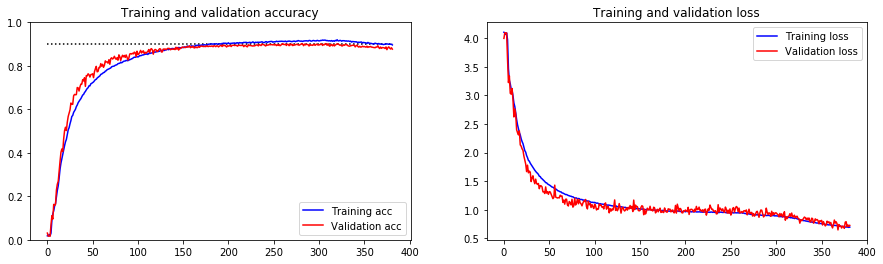

Test acc: 90.227 Val acc: 90.227 (At iteration 281) final training acc: 89.609

####### det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_PERS-MERGED-3BAR_GLOB-norm-drop-0,15-reg-1e-05-MIN_LOSS - 88.660 ######
--------------------- Cross_view ---------------------------------------------


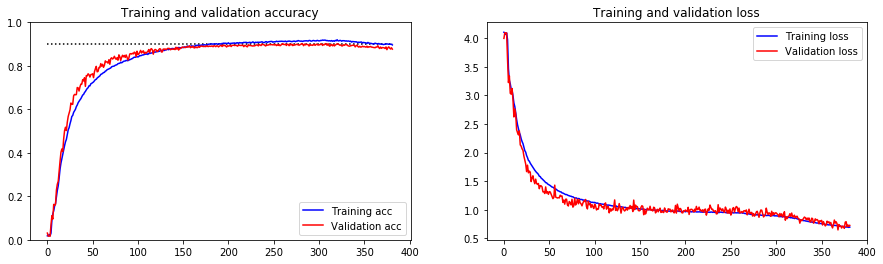

Test acc: 88.660 Val acc: 88.660 (At iteration 368) final training acc: 89.609

####### det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_PERS-norm-drop-0,15-reg-1e-05 - 85.711 ######
--------------------- Cross_view ---------------------------------------------


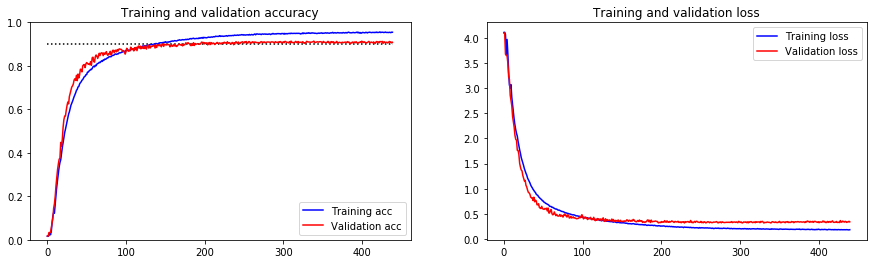

Test acc: 91.398 Val acc: 91.398 (At iteration 339) final training acc: 95.458

--------------------- Cross_subject ---------------------------------------------


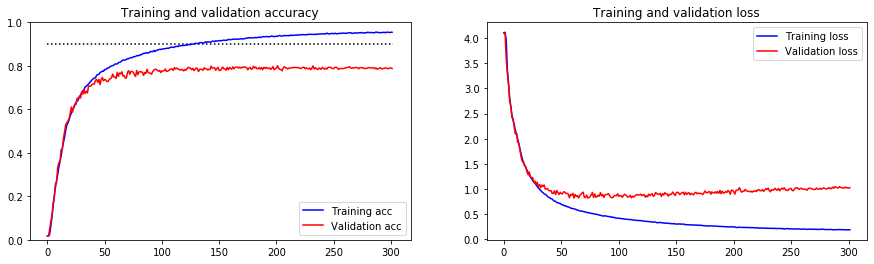

Test acc: 80.024 Val acc: 80.024 (At iteration 201) final training acc: 95.412

####### det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_PERS-norm-drop-0,15-reg-1e-06 - 85.179 ######
--------------------- Cross_view ---------------------------------------------


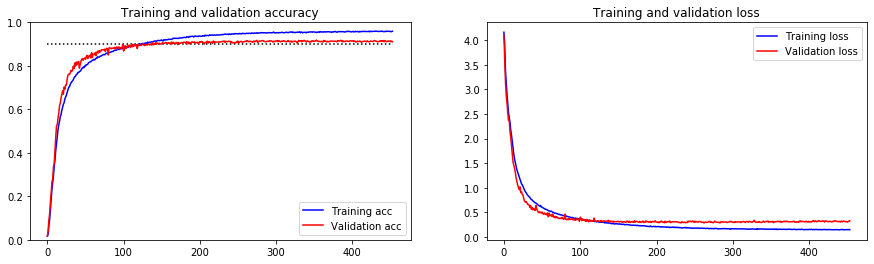

Test acc: 91.862 Val acc: 91.862 (At iteration 353) final training acc: 95.922

--------------------- Cross_subject ---------------------------------------------


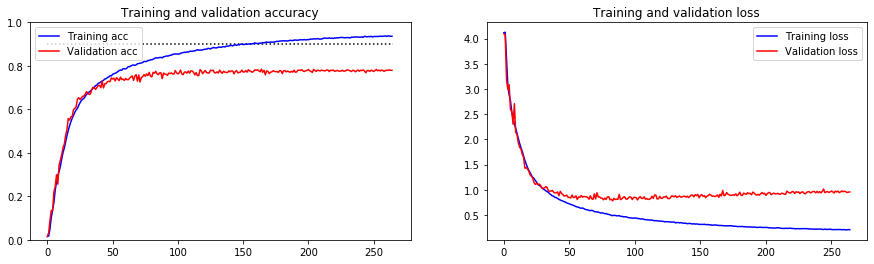

Test acc: 78.496 Val acc: 78.496 (At iteration 164) final training acc: 93.613

####### det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_PERS-norm-drop-0,2-reg-1e-05 - 84.961 ######
--------------------- Cross_view ---------------------------------------------


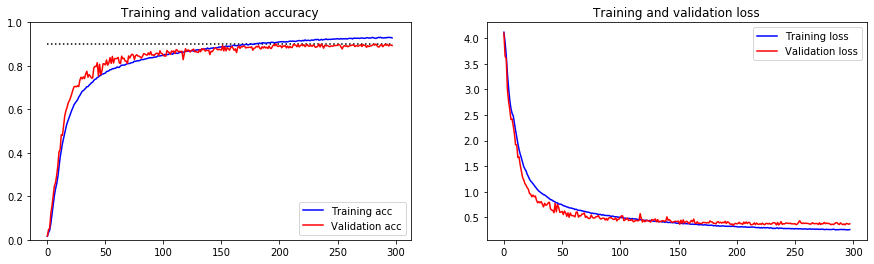

Test acc: 90.164 Val acc: 90.164 (At iteration 197) final training acc: 92.844

--------------------- Cross_subject ---------------------------------------------


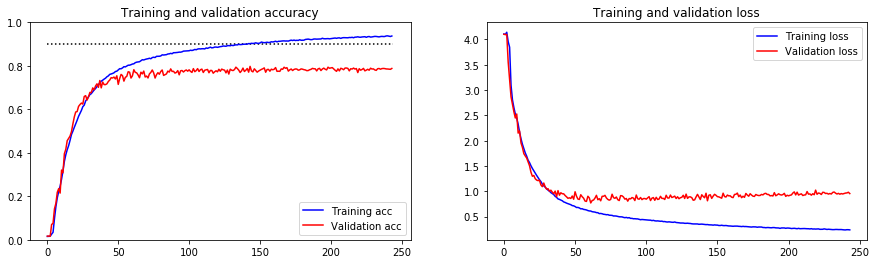

Test acc: 79.758 Val acc: 79.758 (At iteration 143) final training acc: 93.730

####### det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_PERS-norm-drop-0,15-reg-1e-06-MIN_LOSS - 84.561 ######
--------------------- Cross_view ---------------------------------------------


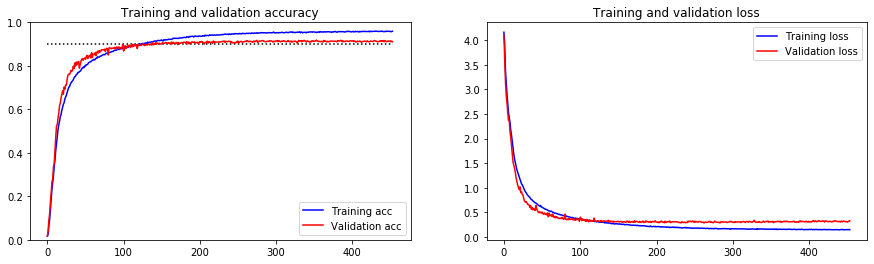

Test acc: 91.646 Val acc: 91.646 (At iteration 283) final training acc: 95.922

--------------------- Cross_subject ---------------------------------------------


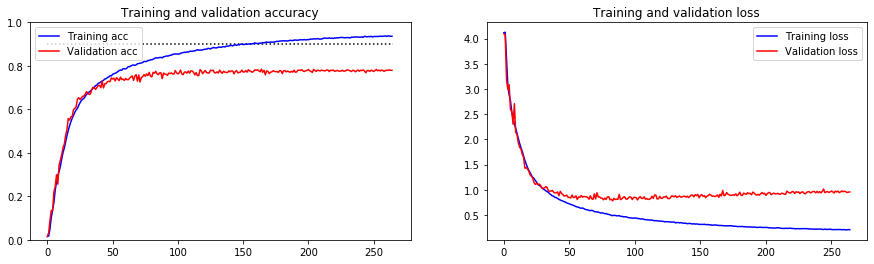

Test acc: 77.476 Val acc: 77.476 (At iteration 83) final training acc: 93.613

####### det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_PERS-norm-drop-0,15-reg-0,0001 - 84.357 ######
--------------------- Cross_view ---------------------------------------------


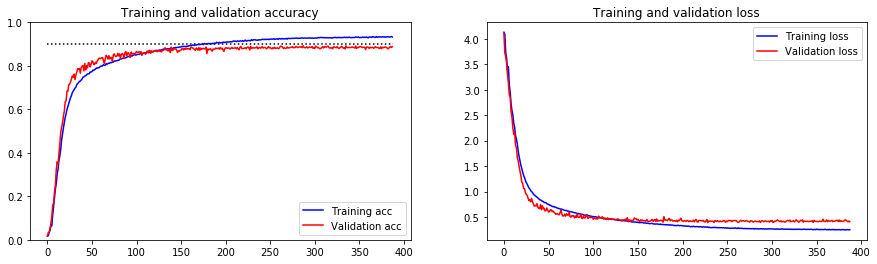

Test acc: 89.209 Val acc: 89.209 (At iteration 287) final training acc: 93.268

--------------------- Cross_subject ---------------------------------------------


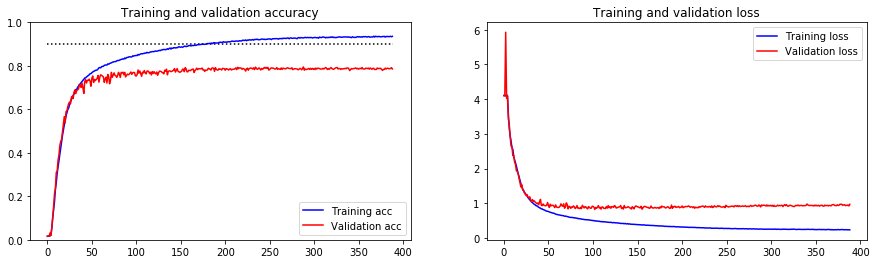

Test acc: 79.505 Val acc: 79.505 (At iteration 288) final training acc: 93.569

####### det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_PERS-norm-drop-0,2-reg-0,0001 - 84.350 ######
--------------------- Cross_view ---------------------------------------------


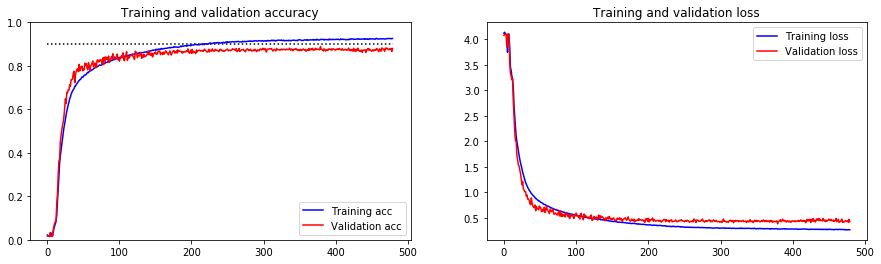

Test acc: 88.882 Val acc: 88.882 (At iteration 379) final training acc: 92.573

--------------------- Cross_subject ---------------------------------------------


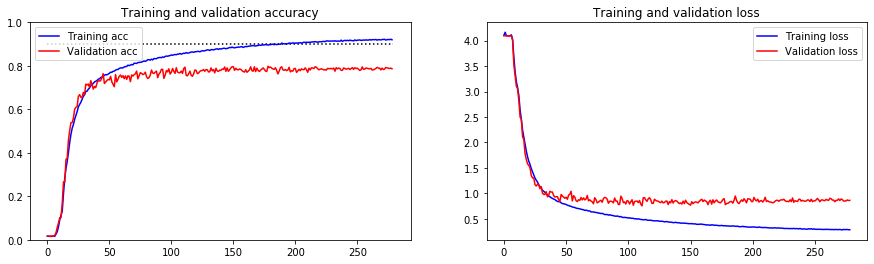

Test acc: 79.819 Val acc: 79.819 (At iteration 178) final training acc: 91.980

####### det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_PERS-norm-drop-0,2-reg-1e-05-MIN_LOSS - 84.194 ######
--------------------- Cross_view ---------------------------------------------


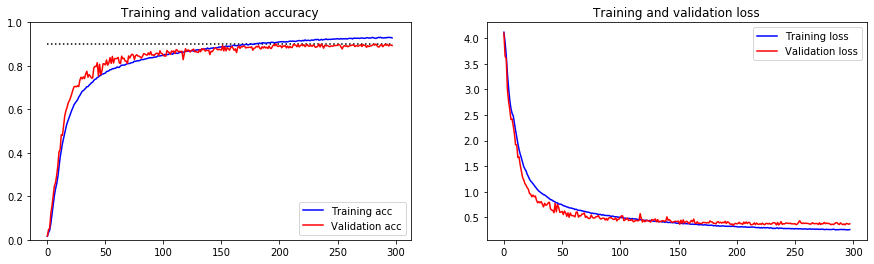

Test acc: 90.164 Val acc: 90.164 (At iteration 197) final training acc: 92.844

--------------------- Cross_subject ---------------------------------------------


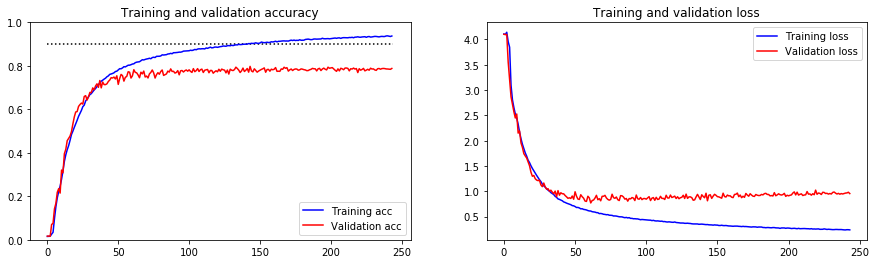

Test acc: 78.225 Val acc: 78.225 (At iteration 61) final training acc: 93.730

####### det-4L-cuda-HU_64-LR_0,01-OFF_0,001-POW_2-rimoz_0-3BAR_PERS-norm-drop-0,15-reg-1e-05-MIN_LOSS - 84.149 ######
--------------------- Cross_view ---------------------------------------------


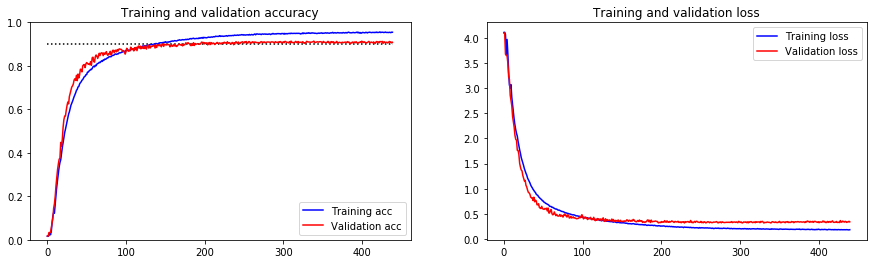

Test acc: 91.287 Val acc: 91.287 (At iteration 330) final training acc: 95.458

--------------------- Cross_subject ---------------------------------------------


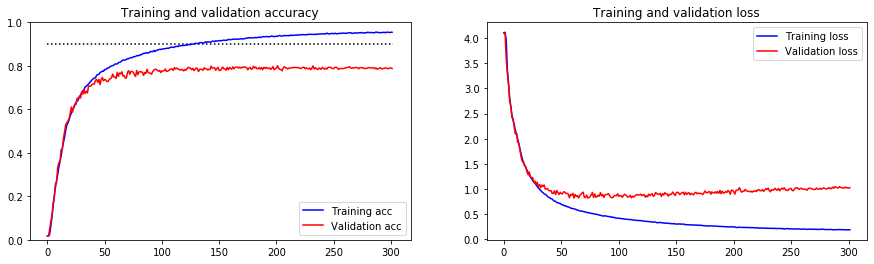

Test acc: 77.011 Val acc: 77.011 (At iteration 61) final training acc: 95.412



In [4]:
import matplotlib.pyplot as plt 
import pickle
from os import scandir
import numpy as np
from os.path import basename #, exists
from parse import parse

SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/" 

################ FROM PREVIOUS GLOBAL RESULT ################
for result in globalResults[:10]:
    print("####### {} - {:.3f} ######".format(cleanForExcel(result["model_name"]),result["avg"]*100))
    
    
#     folder_name_format = "S{:3d}C{:3d}P{:3d}R{:3d}A{:3d}_rgb" #Setup-Camera-Performer-Replication-Action
#     def getConfigurationFromFolderPath(folderPath):
#     setup, camera, performer, replication, label = parse.parse(folder_name_format,basename(folderPath))
    
    foldersToShow = [parse("{}_test_acc",f) for f in list(result.keys()) if parse("{}_test_acc",f) != None]
    for folder in foldersToShow:
        folder = folder[0]
        
        if result[folder+"_test_acc"] == 0:
            continue
            
        print("---------------------",folder,"---------------------------------------------")
            
        historyPath = SAVED_MODEL_FOLDER+folder+"/"+result["model_name"]+".pickle"
        historyPath = historyPath.replace("-MIN_LOSS.pickle",".pickle")
        try:
            with open(historyPath,"rb") as file_in:
                r = pickle.load(file_in)
        except FileNotFoundError:
            print("File non trovato:",historyPath)
            continue

        model_history = r["history"]
        
        if isinstance(model_history, dict):
            acc = model_history['acc']
            val_acc = model_history['val_acc']
            loss = model_history['loss']
            val_loss = model_history['val_loss']
        else:
            acc = model_history.history['accuracy']
            val_acc = model_history.history['val_accuracy']
            loss = model_history.history['loss']
            val_loss = model_history.history['val_loss']
            
        
#         max_iter = 100
        max_iter = len(acc)
        acc = acc[:max_iter]
        val_acc = val_acc[:max_iter]
        loss = loss[:max_iter]
        val_loss = val_loss[:max_iter]


        epochs = range(len(acc))

        plt.figure(figsize = (15,4))
        ax1 = plt.subplot(1, 2, 1)
        ax1.plot(epochs, acc, 'b', label='Training acc')
        ax1.plot(epochs, val_acc, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        ax1.legend()
        ax1.set_ylim(0,1)
        plt.hlines(0.9, 0, len(acc),linestyles="dotted")
#         linestyles : {'solid', 'dashed', 'dashdot', 'dotted'}, optional

        #     plt.figure()
        ax2 = plt.subplot(1, 2, 2)
        ax2.plot(epochs, loss, 'b', label='Training loss')
        ax2.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        ax2.legend()
        

        plt.show()
        i_val_acc = np.argmax(val_acc) if "-MIN_LOSS" not in result["model_name"] else np.argmin(val_loss)
        test_acc = result[folder+"_test_acc"]*100
        value_val_acc = val_acc[i_val_acc]*100
        
        training_acc = acc[-1]*100
        print("Test acc: {:.3f} Val acc: {:.3f} (At iteration {}) final training acc: {:.3f}".format(test_acc,value_val_acc,i_val_acc,training_acc))
        if "loaded_from" in r.keys():
            print("Loaded from:", cleanForExcel(r["loaded_from"].split("/")[-1]))
        print("")

### Visualize missclassified

In [ ]:
import seaborn as sn
def plotConfusionMatrixes(conf_mat_val, conf_mat_test, labelString = None):
    plt.figure(figsize = (25,35))
    ax1 = plt.subplot(2, 1, 1)
    ax1 = sn.heatmap(conf_mat_val, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.title("VALIDATION SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15
    
    ax2 = plt.subplot(2, 1, 2)
    
    ax2 = sn.heatmap(conf_mat_test, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.title("TEST SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15

    plt.show()

In [ ]:
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# label_order = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 
#                '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', 
#                '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', 
#                '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', 
#                '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', 
#                '6', '60', '7', '8', '9']


SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
# SAVED_MODEL_FOLDER += "top+Senesi_Cross_view/"
# SAVED_MODEL_FOLDER += "top+Senesi_Cross_subject/"
# SAVED_MODEL_FOLDER += "Cross_view_mini/"  
# SAVED_MODEL_FOLDER += "Cross_subject_mini/" 
SAVED_MODEL_FOLDER += "Cross_view/"  
# SAVED_MODEL_FOLDER += "Cross_subject/"

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)

loadedResults.sort(key=lambda x : x["test_acc"],reverse=True)
result = loadedResults[0]

y_val_pred = result["y_val_pred"]
y_val_true = result["y_val_true"]
y_test_pred = result["y_test_pred"]
y_test_true = result["y_test_true"]
val_acc = result["val_acc"]
test_acc = result["test_acc"]
print("Val acc:",val_acc)
print("Test acc:",test_acc)

# import pandas as pd
# y_actu_val = pd.Series(y_val_true, name='Actual')
# y_pred_val = pd.Series(y_val_pred, name='Predicted')
# conf_mat_val = pd.crosstab(y_actu_val, y_pred_val, rownames=['Actual'], colnames=['Predicted']
# #                            , margins=True
#                           )

# y_actu_test = pd.Series(y_test_true, name='Actual')
# y_pred_test = pd.Series(y_test_pred, name='Predicted')
# conf_mat_test = pd.crosstab(y_actu_test, y_pred_test, rownames=['Actual'], colnames=['Predicted']
# #                             , margins=True
#                            )

conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred)            
conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred)

# # normalize
# conf_mat_val = conf_mat_val / conf_mat_val.sum(axis=1)
# conf_mat_test = conf_mat_test / conf_mat_test.sum(axis=1)

labels = range(1,len(conf_mat_val[0])+1)
plotConfusionMatrixes(conf_mat_val,conf_mat_test,labelString=labels)

length = len(conf_mat_test)

till = 21
mat_test = conf_mat_test.copy()
np.fill_diagonal(mat_test, 0)
np.argsort(mat_test.ravel())[::-1]
test_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_test.ravel())[::-1]]
print("TEST PAIR CONFUSED:\n", test_indexs[:till])
print("TEST TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(test_indexs[:till])))) # remove duplicates


mat_val = conf_mat_val.copy()
np.fill_diagonal(mat_val, 0)
np.argsort(mat_val.ravel())[::-1]
val_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_val.ravel())[::-1]]
print("\nVAL PAIR CONFUSED:\n", val_indexs[:till])
print("VAL TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(val_indexs[:till])))) # remove duplicates

commonPairs = [test_indexs[r] for r in range(till) if test_indexs[r] in val_indexs[:till]]
print("\nCOMMON MOST CONFUSED:\n", commonPairs)
commonTopic = list(dict.fromkeys(np.concatenate(commonPairs)))
print("COMMON TOPIC CONFUSED:\n", commonTopic)

print("lenght:" , len(commonTopic))


In [ ]:
#CROSS_SUBJECT
till = 21
mat_test = conf_mat_test.copy()
np.fill_diagonal(mat_test, 0)
np.argsort(mat_test.ravel())[::-1]
test_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_test.ravel())[::-1]]
print("TEST PAIR CONFUSED:\n", test_indexs[:till])
print("TEST TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(test_indexs[:till])))) # remove duplicates


mat_val = conf_mat_val.copy()
np.fill_diagonal(mat_val, 0)
np.argsort(mat_val.ravel())[::-1]
val_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_val.ravel())[::-1]]
print("\nVAL PAIR CONFUSED:\n", val_indexs[:till])
print("VAL TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(val_indexs[:till])))) # remove duplicates

commonPairs = [test_indexs[r] for r in range(till) if test_indexs[r] in val_indexs[:till]]
print("\nCOMMON MOST CONFUSED:\n", commonPairs)
commonTopic = list(dict.fromkeys(np.concatenate(commonPairs)))
print("COMMON TOPIC CONFUSED:\n", commonTopic)

print("lenght:" , len(commonTopic))


In [ ]:
#CROSS_VIEW
till = 21
mat_test = conf_mat_test.copy()
np.fill_diagonal(mat_test, 0)
np.argsort(mat_test.ravel())[::-1]
test_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_test.ravel())[::-1]]
print("TEST PAIR CONFUSED:\n", test_indexs[:till])
print("TEST TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(test_indexs[:till])))) # remove duplicates


mat_val = conf_mat_val.copy()
np.fill_diagonal(mat_val, 0)
np.argsort(mat_val.ravel())[::-1]
val_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_val.ravel())[::-1]]
print("\nVAL PAIR CONFUSED:\n", val_indexs[:till])
print("VAL TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(val_indexs[:till])))) # remove duplicates

commonPairs = [test_indexs[r] for r in range(till) if test_indexs[r] in val_indexs[:till]]
print("\nCOMMON MOST CONFUSED:\n", commonPairs)
commonTopic = list(dict.fromkeys(np.concatenate(commonPairs)))
print("COMMON TOPIC CONFUSED:\n", commonTopic)

print("lenght:" , len(commonTopic))


In [14]:
view = [34, 10, 30, 12, 29, 11, 53, 57, 17, 16, 49, 23] # toughest cross_view
subj = [12, 30, 10, 34, 11, 29, 31, 32, 17, 16, 53, 57] # toughest cross_subject
subj.sort()
view.sort()
print("subj =", subj)
print("view =", view)

subj = [10, 11, 12, 16, 17, 29, 30, 31, 32, 34, 53, 57]
view = [10, 11, 12, 16, 17, 23, 29, 30, 34, 49, 53, 57]


## Re-evaluating model

In [41]:
import dill
import pickle
import numpy as np
from keras import models,layers
from keras.layers import LSTM, CuDNNLSTM, Dropout, Concatenate , Dense
from keras.models import Model,load_model
from keras.regularizers import l2 #, l1
from keras.callbacks import EarlyStopping,ModelCheckpoint
from os import scandir
from os.path import exists
import shutil 

DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"

MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
fullModelNameToEvaluate = "keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-HU_128-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0"

# folder_to_evaluate = "Cross_view/"  
folder_to_evaluate = "Cross_view_mini/"  
# folder_to_evaluate = "Cross_subject/"

completeFolderPath = SAVED_MODEL_FOLDER+folder_to_evaluate


assert exists(completeFolderPath+"summaryResults-Copy1.pickle")
print("Loading previous results...")
with open(completeFolderPath+"summaryResults-Copy1.pickle","rb") as handle:
    results = pickle.load(handle)

# results.sort(key=lambda x : x["test_acc"],reverse=True)

accessoriesPath = completeFolderPath+fullModelNameToEvaluate+".pickle"

print("Loading accessories:",accessoriesPath)
with open(accessoriesPath,"rb") as handle:
    accessories = pickle.load(handle)
            
print("Loading functions...")
loaded_specific_functions = [dill.loads(x) for x in accessories["spec_fun_DILL"]]

## SPECIFIC FUNCTIONS
specificFunctions = []
for elem in loaded_specific_functions:
    if callable(elem):
        specificFunctions.append(elem)
    elif not callable(elem):
        specificFunctions.append(elem[0])
                

if folder_to_evaluate.endswith("Cross_subject/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT-dataset.pickle"           
elif folder_to_evaluate.endswith("Cross_view/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW-dataset.pickle"
if folder_to_evaluate.endswith("Cross_subject_mini/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_MINI-dataset.pickle"           
elif folder_to_evaluate.endswith("Cross_view_mini/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_MINI-dataset.pickle"
else:
    raise Exception("folder not recognised")
    
### LOADING DATASET ###
print("#### Loading dataset: ", datasetName)
train_set, val_set, test_set = getData(datasetName)

X_train, y_train, X_val, y_val, X_test, y_test, encodingLabels = preprocessData(train_set, 
                                                                               val_set, 
                                                                               test_set,  
                                                                               specificFunctions)
encodingLabels = [int(i) for i in encodingLabels]

model = load_model(completeFolderPath+fullModelNameToEvaluate+".h5")
### EVALUATING MODEL ###      
val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred = getValTestAccuracy(model,X_val,y_val,X_test,y_test, encodingLabels)
print("Model for MAX ACCURACY test_acc: {:.3f} val_acc: {:.3f}".format(test_acc*100,val_acc*100))


minLossModelName = "{}-min_val_loss.hdf5".format(completeFolderPath+fullModelNameToEvaluate)
model_minLoss = load_model(minLossModelName)
val_acc_minLoss, test_acc_minLoss, y_val_true, y_val_pred_minLoss, y_test_true, y_test_pred_minLoss = getValTestAccuracy(model_minLoss,X_val,y_val,X_test,y_test,encodingLabels)
print("Model for MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss*100,val_acc_minLoss*100))

### SAVING RESULTS ###
newEvaluation = {"val_acc": val_acc, 
                "test_acc": test_acc, 
                "model_name": fullModelNameToEvaluate, 
                "y_val_true": y_val_true,
                "y_val_pred": y_val_pred,
                "y_test_true": y_test_true,
                "y_test_pred": y_test_pred,

                "val_acc_minLoss": val_acc_minLoss, 
                "test_acc_minLoss": test_acc_minLoss, 
                "y_val_pred_minLoss": y_val_pred_minLoss,
                "y_test_pred_minLoss": y_test_pred_minLoss
               }

previousResult = [v for v in results
     if v["model_name"] == fullModelNameToEvaluate]
isPreviousResult = np.array(results) == previousResult
indexPreviousResult = np.array(range(len(results)))[isPreviousResult]
if len(indexPreviousResult) == 0:
    print("model evaluated for the first time")
    results.append(newEvaluation)
else:
    print("substituting evaluation for the model")
    results[indexPreviousResult[0]] = newEvaluation



print("Dumping results...")
with open(completeFolderPath+"summaryResults.pickle","wb") as handle:
    pickle.dump(results, handle)

print("DONE!")


Loading previous results...
Loading accessories: /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-HU_128-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0.pickle
Loading functions...
#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_VIEW_MINI-dataset.pickle
train_set shape: (4044,)
train_set zero elements: 20332/16346622 (0.12%)
val_set shape: (1012,)
val_set zero elements: 2618/4066196 (0.064%)
test_set shape: (2528,)
test_set zero elements: 11390/10189664 (0.11%)
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
removing zeros from dataset
removing zeros from dataset
removing zeros from dataset
Adapting the data to the CENTER of each VIDEO
Adapting the data to the CENTER of each VIDEO
Ada

/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


### Visualize nextFrameResults

In [32]:
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"

model_name = "keypoint_rcnn_X_101_32x8d_FPN_3x"
# model_name = "PoseNet-101"
datasetName = DATASET_FOLDER+model_name+"-CROSS_SUBJECT_MINI-dataset.pickle"

train_set, val_set, test_set = getData(datasetName)

train_set[0] = removeZerosFromDataset(train_set[0])
# train_set[0] = relativeToNextFrameBuilder(11)(train_set[0])
# train_set[0] = relativeToUpperMiddleBottomCentersOfVideo(train_set[0])
train_set[0] = cumulativeDifferences(train_set[0])
# train_set[0] = normalizeVideosXYInpid(train_set[0])
train_set[0] = normalizeVideos(train_set[0])

# val_set[0] = removeZerosFromDataset(val_set[0])
# test_set[0] = removeZerosFromDataset(test_set[0])

# labels = ["train_set", "val_set", "test_set"]
# for i,dataset in enumerate([train_set, val_set, test_set]):
#     totalsize, zero_elements =  getZeroStatsForDataset(dataset[0])
#     print("{} shape: {}".format(labels[i], dataset[0].shape))
#     print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))
        
print("DONE!")

train_set shape: (6451,)
train_set zero elements: 18496/19641018 (0.094%)
val_set shape: (1613,)
val_set zero elements: 6358/4906268 (0.13%)
test_set shape: (3312,)
test_set zero elements: 5032/10836820 (0.046%)
removing zeros from dataset
Adapting the data as the CUMULATIVE DIFFERENCES of consecutive frames
normalising EACH VIDEO, considering x and y TOGETHER
DONE!


In [34]:
from random import randint
video_ids = [randint(0,len(train_set[0])) for i in range(15)]

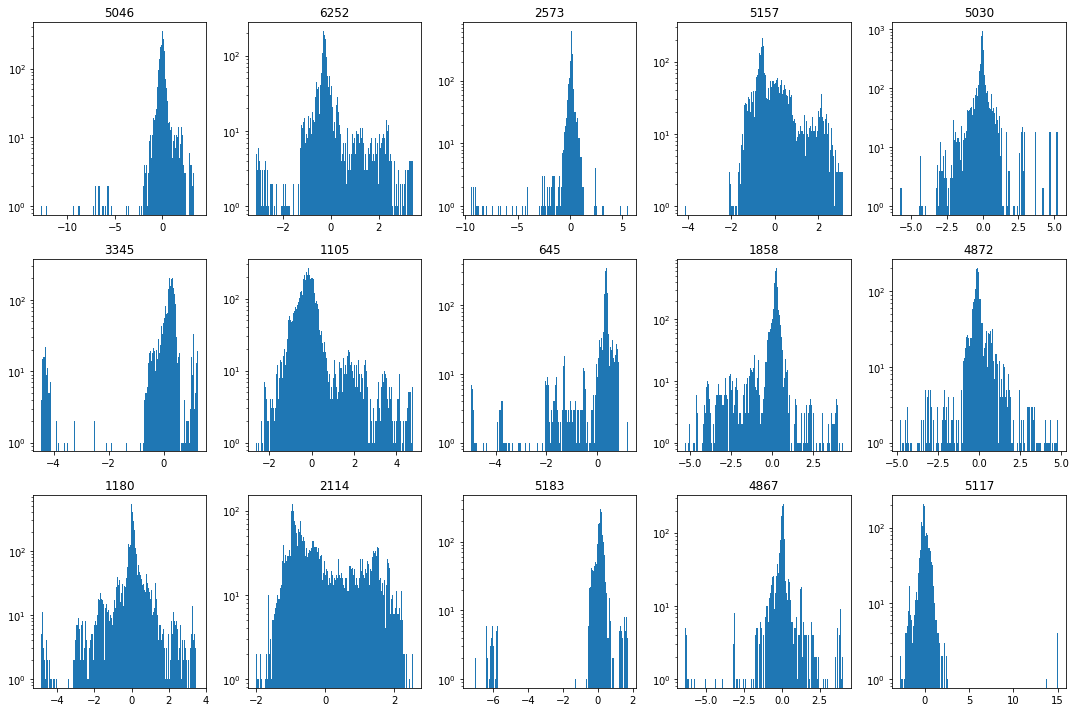

In [35]:
# CUMULATIVE DIFFERENCES
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

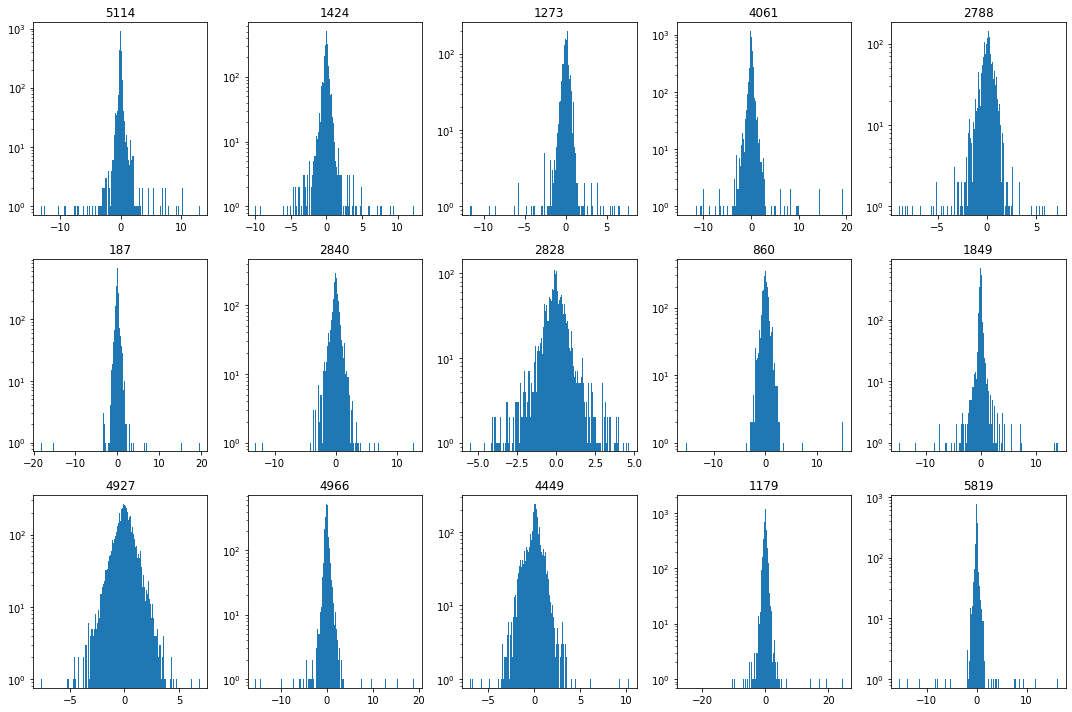

In [255]:
# NEXT FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

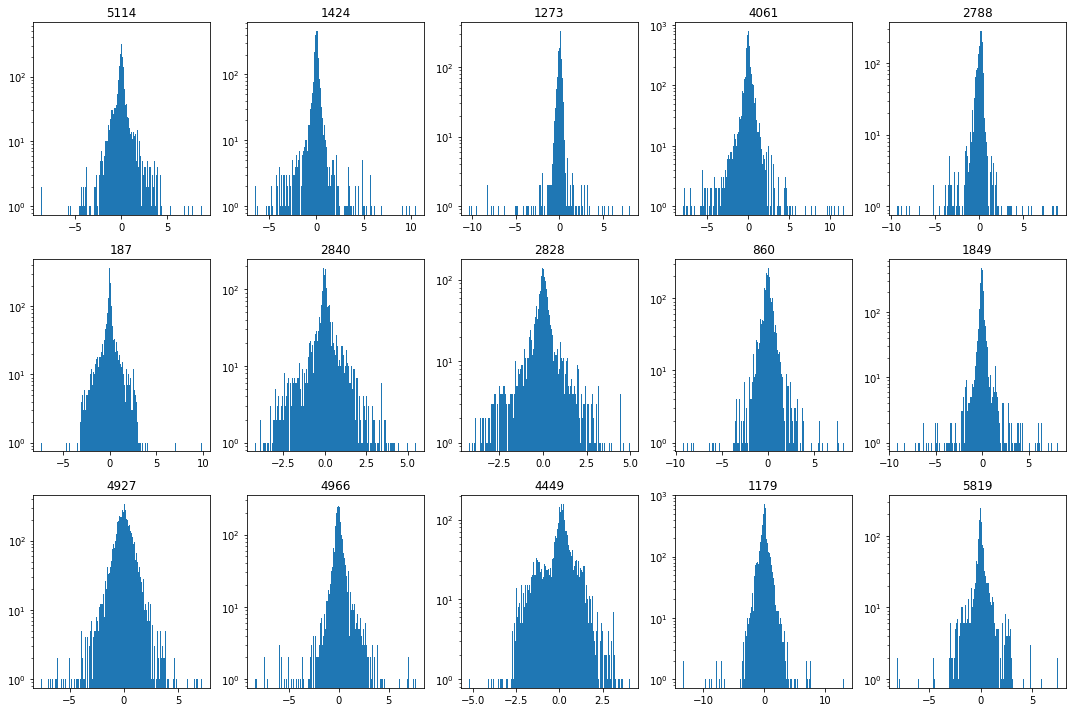

In [259]:
# NEXT 5 FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

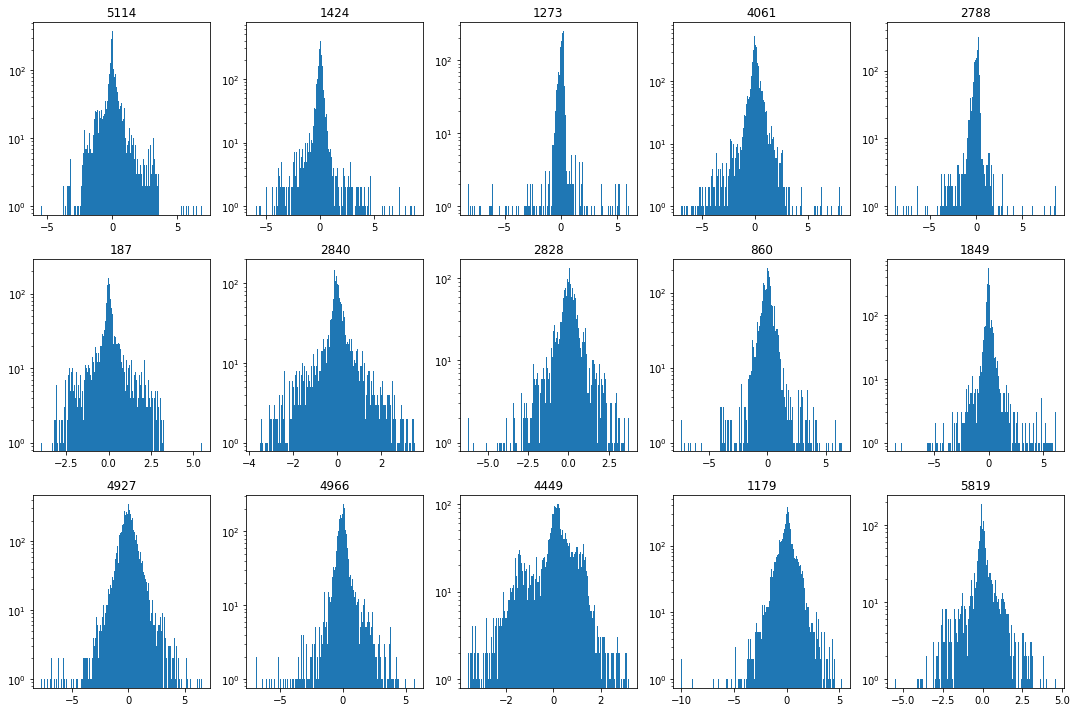

In [261]:
# NEXT 11 FRAME nomalizing INDIPENDENTLY
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

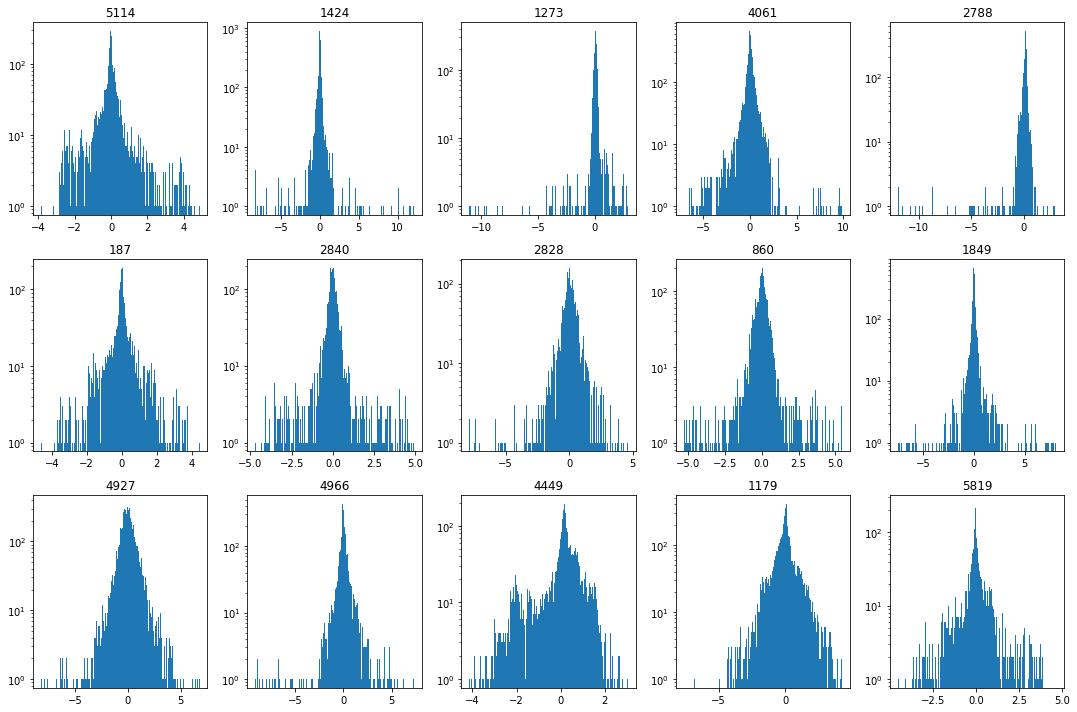

In [267]:
# NEXT 11 FRAME nomalizing TOGETHER
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

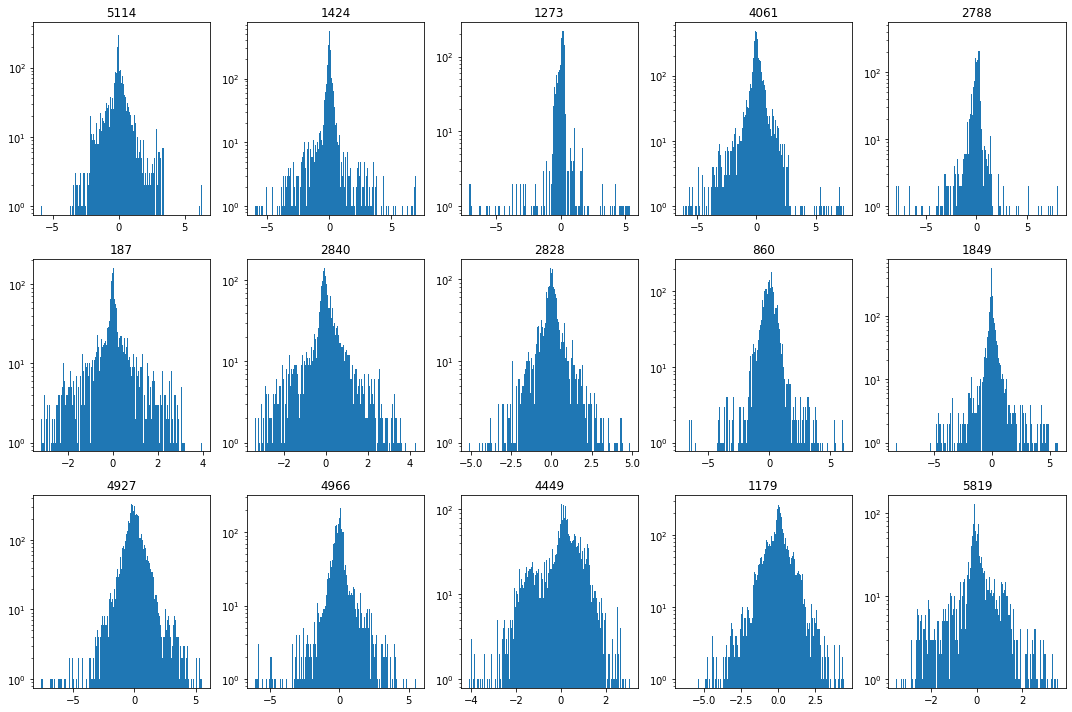

In [263]:
# NEXT 15 FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

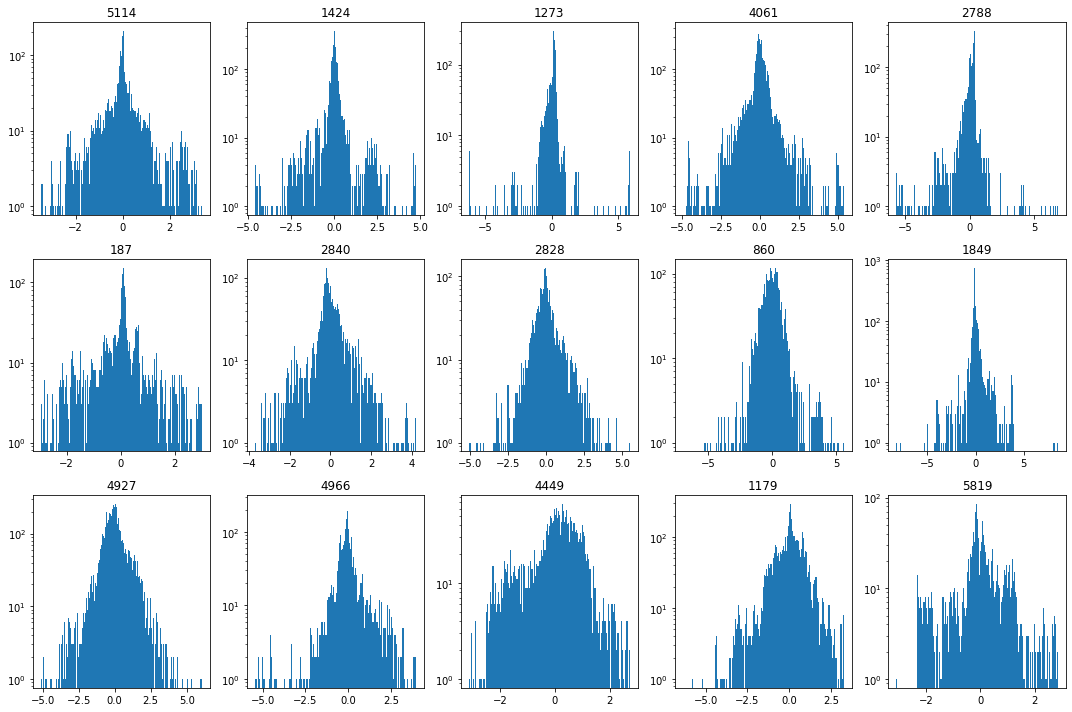

In [265]:
# NEXT 30 FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

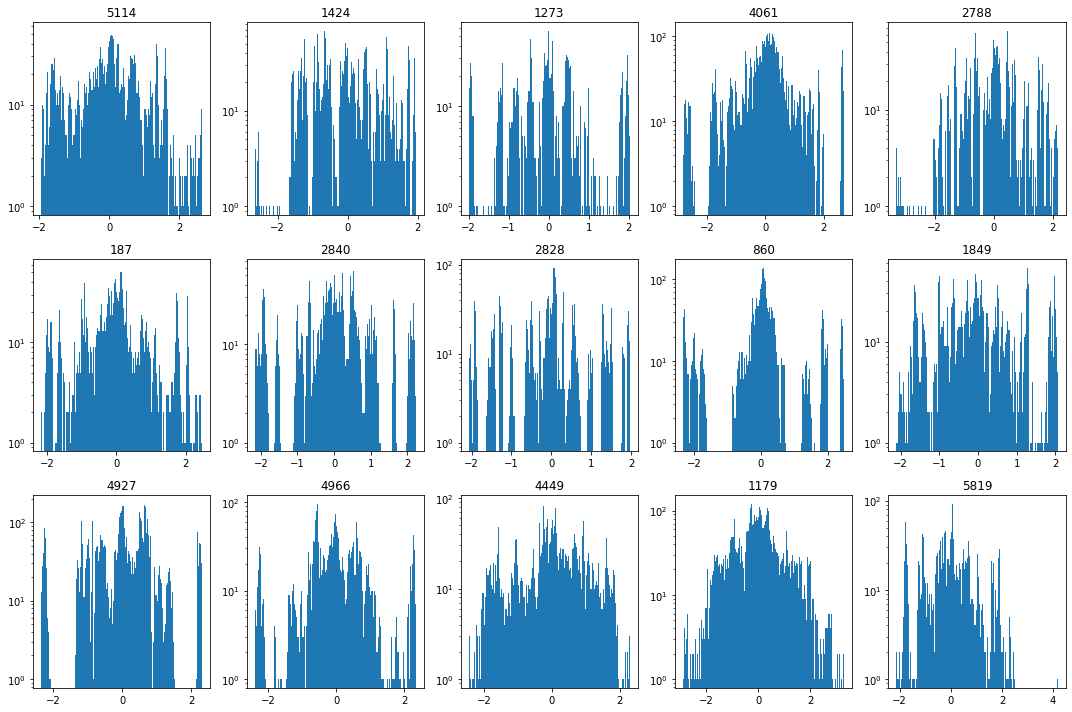

In [277]:
# 3BAR
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

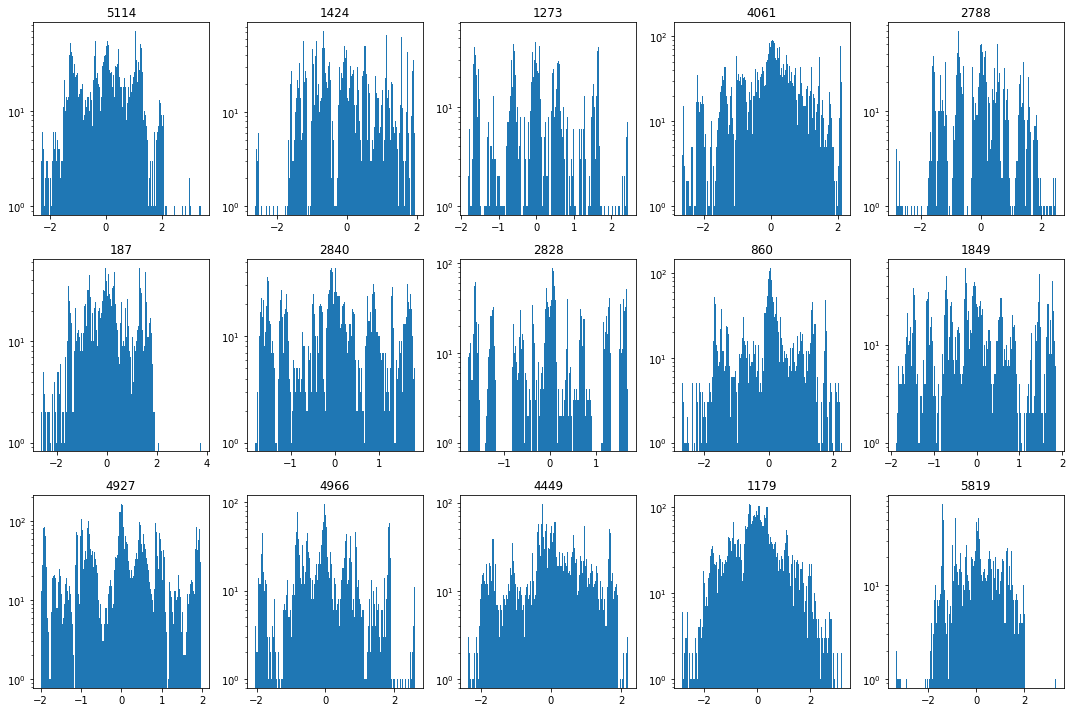

In [275]:
# 3BAR INDIP
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

## CLEAN Results

In [112]:
#remove last element of summary result

SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
# SAVED_MODEL_FOLDER += "Cross_view/"
SAVED_MODEL_FOLDER += "Cross_subject/"

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)

print("Removing",loadedResults[-1]['model_name'])
print ("From",SAVED_MODEL_FOLDER+"summaryResults.pickle")

# loadedResults = loadedResults[:-1]
# with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","wb") as handle:
#             pickle.dump(loadedResults, handle)

Removing keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeTo5CentersNTURGBofVideo-drop-0.1-rec_drop-0.1-norm
From /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Senesi/summaryResults.pickle


## Removing accessories file for low results

In [5]:
from os.path import isfile, isdir, join, exists,getsize,basename
from os import scandir
import pickle

NUMBER_OF_BEST_MODEL_TO_SAVE = 20

SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
SAVED_MODEL_FOLDER += "Cross_view_mini/"
# SAVED_MODEL_FOLDER += "Cross_subject_mini/"


accessoryFileList = [f.path for f in scandir(SAVED_MODEL_FOLDER) 
                       if f.path.endswith(".pickle") 
                       and "summaryResult" not in basename(f)]

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)
        
loadedResults.sort(key=lambda x : x["test_acc"], reverse=True)
assert NUMBER_OF_BEST_MODEL_TO_SAVE > 10
bestModels = [r['model_name'] for r in loadedResults[:NUMBER_OF_BEST_MODEL_TO_SAVE]]

for accessoryFile in accessoryFileList:
    modelNameToCheck = basename(accessoryFile).replace(".pickle","")
    if modelNameToCheck not in bestModels:
        print("Removing",accessoryFile)
        !rm $accessoryFile

Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.1-reg-0.001.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-normalizeVideosXYInpid-drop-0.5-reg-0.1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-reg-0.001.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.5-reg-0.001.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_

Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-reg-0.1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.05-rec_drop-0.05.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-normalizeVideosXYInpid-drop-0-rec_drop-0.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-normalizeVideos-drop-0-rec_drop-0.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-

Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-reg-1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-normalizeVideos-drop-0.1-rec_drop-0.1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.1-reg-0.pickle


# AREA TEST

## Testing relativeToNextFrameFunction

## Smoothing test

In [35]:
MODEL_NAME = "PoseNet-101"
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
print("#### Loading dataset: ", datasetName)
train_set, val_set, test_set = getData(datasetName)

#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/PoseNet-101-SPLIT-dataset.pickle
train_set shape: (5460,)
train_set zero elements: 58106/13984574 (0.42%)
val_set shape: (1365,)
val_set zero elements: 15980/3509310 (0.46%)
test_set shape: (759,)
test_set zero elements: 9588/1973564 (0.49%)


doing video 0
doing video 1


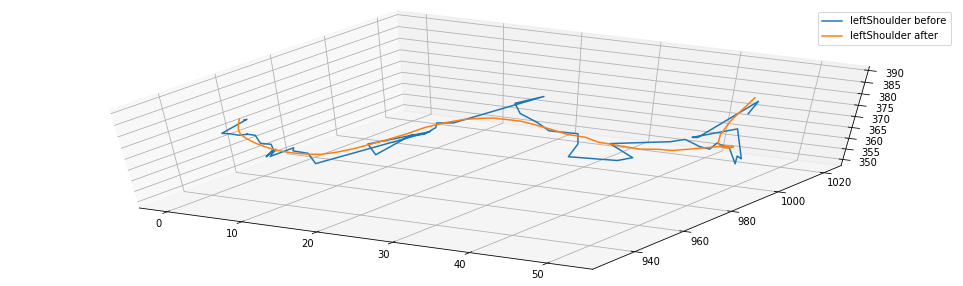

In [36]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
window = 29
order = 5
# listOfPoints = list(range(17))
listOfPoints = [5
#                 ,7,9
               ]

fig = plt.figure()
fig.set_size_inches( (17, len(listOfPoints)*5) )
for i, p in enumerate(listOfPoints):
    
    ax = fig.add_subplot(len(listOfPoints), 1, i+1, projection='3d')
    
    ax.view_init(50, -60)
    x, y = zip(*[(f[p][0], f[p][1]) for f in train_set[0][0]])
    z = np.arange(len(x))
    ax.plot(z,y,x,label=legend[p]+" before")
    
    smoothingPoints(29,5)[0](train_set[0])
    
    x2, y2 = zip(*[(f[p][0], f[p][1]) for f in train_set[0][0]])
    z2 = np.arange(len(x))
    ax.plot(z2,y2,x2,label=legend[p]+" after")
    
    ax.legend()

plt.show()
  

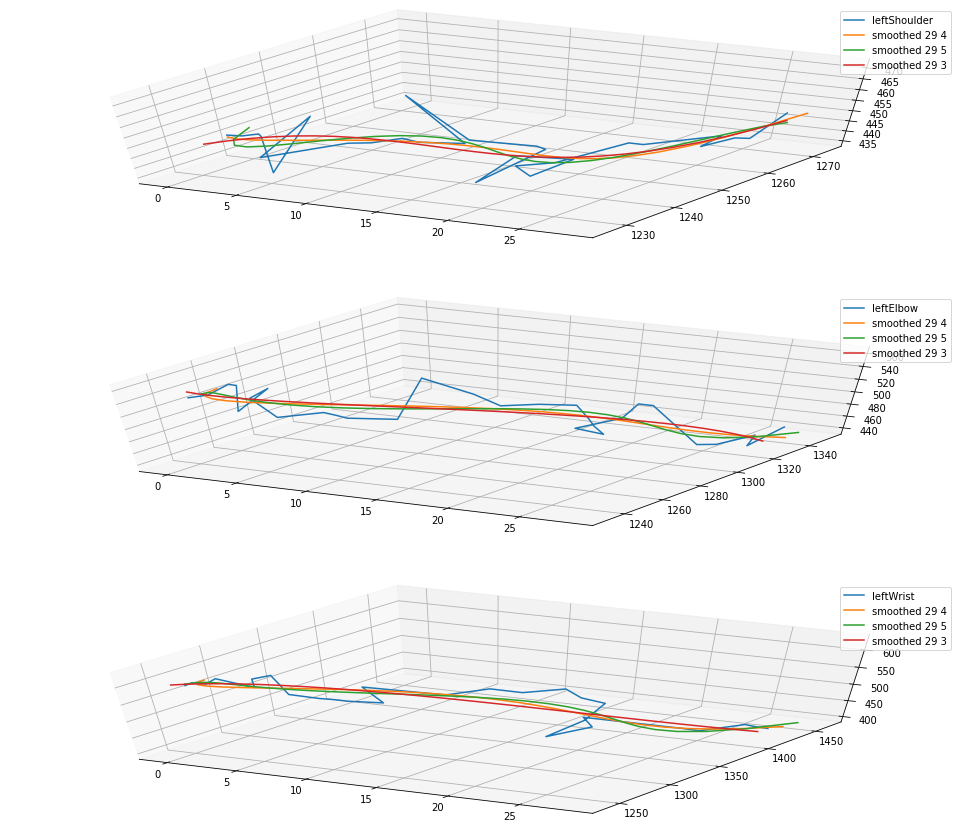

In [91]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
window = 29
order = 5
# listOfPoints = list(range(17))
listOfPoints = [5
#                 ,7,9
               ]

fig = plt.figure()
fig.set_size_inches( (17, len(listOfPoints)*5) )
for i, p in enumerate(listOfPoints):
    
    ax = fig.add_subplot(len(listOfPoints), 1, i+1, projection='3d')
    
    ax.view_init(50, -60)
    x, y = zip(*[(f[p][0], f[p][1]) for f in randomVideo])
    z = np.arange(len(x))
    ax.plot(z,y,x,label=legend[p])
    
    smooth_y=signal.savgol_filter(y, window, order) 
    smooth_x=signal.savgol_filter(x, window, order)
    ax.plot(z,smooth_y,smooth_x,label="smoothed {} {}".format(window,order))
    
    
    ax.legend()

plt.show()
  

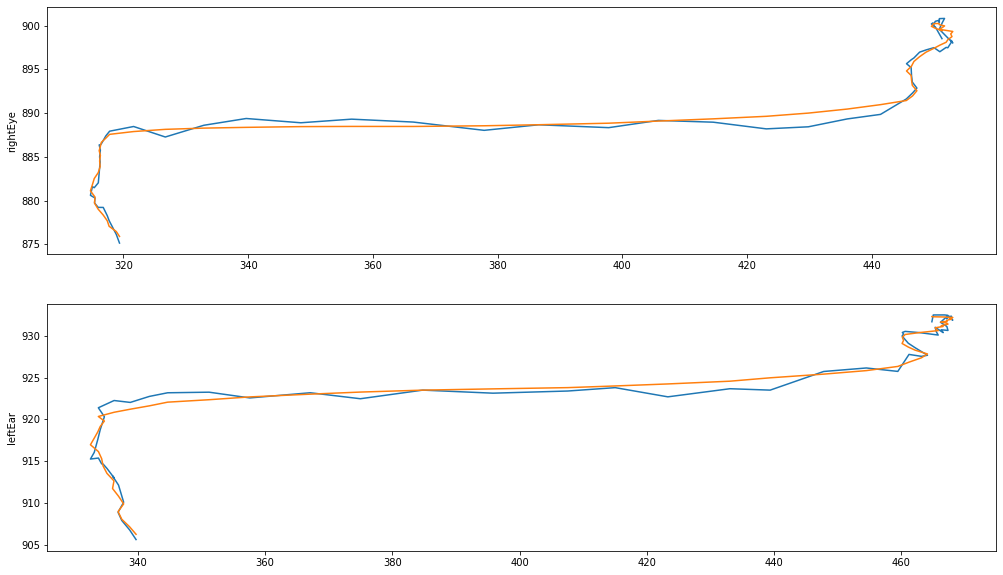

In [302]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
listOfPoints = [2,3]
fig, axes = plt.subplots(nrows=len(listOfPoints), ncols=1)
fig.set_size_inches((17,len(listOfPoints)*5))
for i, p in enumerate(listOfPoints):
    axes[i].set_ylabel(legend[p])
    x, y = zip(*[(f[p][0], f[p][1]) for f in randomVideo])
    # series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    ts = Series(y, index=x)
    # ts = ts.cumsum()
    ts.plot(ax=axes[i])
    
    smooth_y=signal.savgol_filter(ts.get_values(),
                           29, # window size used for filtering
                           3), # order of fitted polynomial

    ts2 = Series(smooth_y[0], index=x)

    ts2.plot(ax=axes[i])

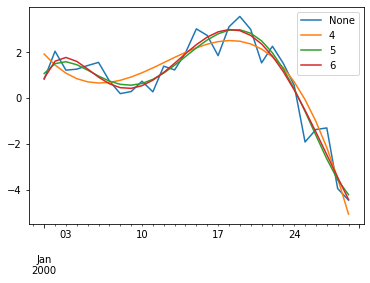

In [115]:
from pandas import read_csv, Series,date_range
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
from numpy import random
from numpy.random import randn
from scipy import signal


# series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
ts = Series(randn(29), index=date_range('1/1/2000', periods=29))
ts = ts.cumsum()
ts.plot()

y1=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       4) # order of fitted polynomial  
ts2 = Series(y1, index=date_range('1/1/2000', periods=29))
ts2.plot(label="4")


y2=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       5) # order of fitted polynomial
ts3 = Series(y2, index=date_range('1/1/2000', periods=29))
ts3.plot(label="5")


y3=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       6) # order of fitted polynomial
ts4 = Series(y3, index=date_range('1/1/2000', periods=29))

ts4.plot(label="6")
plt.legend()

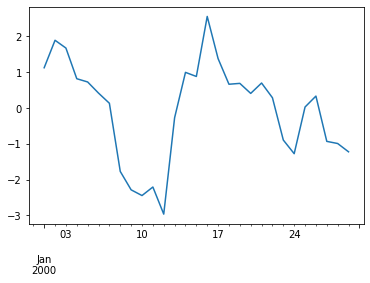

In [7]:
from pandas import read_csv, Series,date_range
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
from numpy import random
from numpy.random import randn
from scipy import signal
import matplotlib.pyplot as plt

# series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
ts = Series(randn(29), index=date_range('1/1/2000', periods=29))
ts = ts.cumsum()
ts.plot()

y1= ts.get_values()


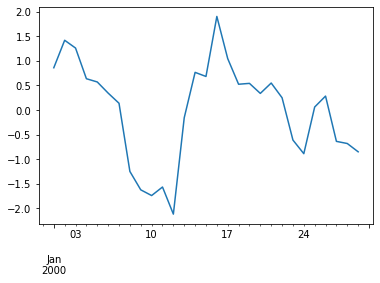

In [8]:
y1Mean = y1.mean()
y1Std = y1.std()
y1 = (y1-y1Mean)/y1Std
ts2 = Series(y1, index=date_range('1/1/2000', periods=29))
ts2.plot(label="NORM")

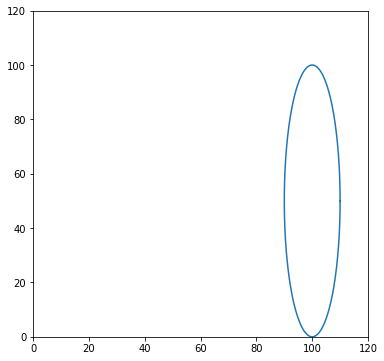

In [47]:
from numpy import *
from matplotlib.pyplot import *
from matplotlib.pyplot import figure
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D


# legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
#           "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
#           "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
# listOfPoints = [2,3]
# fig, axes = plt.subplots(nrows=len(listOfPoints), ncols=1)

plt.figure(figsize=(6,6))

t = linspace(0,360,360)
x = 10*cos(radians(t))+100 # major axis of ellipse
y = 50*sin(radians(t))+50
plt.xlim(0,120)
plt.ylim(0,120)
plot(x,y)
show()

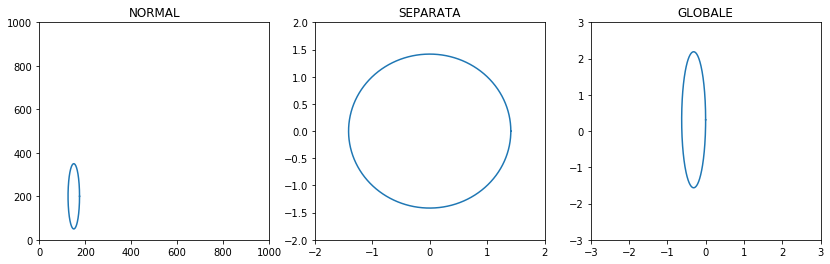

In [90]:
plt.figure(figsize=(14,4))
t = linspace(0,360,360)
x = 25*cos(radians(t))+150# major axis of ellipse
y = 150*sin(radians(t))+200

# plt.figure(figsize = (5,5))
ax1 = plt.subplot(1, 3, 1)
plt.title('NORMAL')
ax1.set_xlim(0,1000)
ax1.set_ylim(0,1000)
ax1.plot(x,y)
# plot(x,y)

meanX = x.mean()
stdX = x.std()
meanY = y.mean()
stdY = y.std()
meanGlobal = np.concatenate((x,y)).mean()
stdGlobal = np.concatenate((x,y)).std()

# NORM SEPARATA
xSep = (x-meanX)/stdX
ySep = (y-meanY)/stdY
ax2 = plt.subplot(1, 3, 2)
plt.title('SEPARATA')
ax2.set_xlim(-2,2)
ax2.set_ylim(-2,2)
ax2.plot(xSep,ySep)

# NORM GLOBALE
xGlob = (x-meanGlobal)/stdGlobal
yGlob = (y-meanGlobal)/stdGlobal
ax3 = plt.subplot(1, 3, 3)
ax3.set_xlim(-3,3)
ax3.set_ylim(-3,3)
plt.title('GLOBALE')
ax3.plot(xGlob,yGlob)

plt.show()

In [23]:
np.concatenate((x,y))

array([1.10000000e+02, 1.09998468e+02, 1.09993874e+02, 1.09986219e+02,
       1.09975505e+02, 1.09961735e+02, 1.09944914e+02, 1.09925046e+02,
       1.09902139e+02, 1.09876198e+02, 1.09847232e+02, 1.09815250e+02,
       1.09780261e+02, 1.09742277e+02, 1.09701308e+02, 1.09657368e+02,
       1.09610470e+02, 1.09560628e+02, 1.09507857e+02, 1.09452174e+02,
       1.09393596e+02, 1.09332141e+02, 1.09267827e+02, 1.09200674e+02,
       1.09130703e+02, 1.09057935e+02, 1.08982392e+02, 1.08904098e+02,
       1.08823077e+02, 1.08739353e+02, 1.08652952e+02, 1.08563901e+02,
       1.08472227e+02, 1.08377957e+02, 1.08281121e+02, 1.08181749e+02,
       1.08079870e+02, 1.07975517e+02, 1.07868720e+02, 1.07759513e+02,
       1.07647930e+02, 1.07534004e+02, 1.07417770e+02, 1.07299264e+02,
       1.07178522e+02, 1.07055581e+02, 1.06930479e+02, 1.06803255e+02,
       1.06673946e+02, 1.06542593e+02, 1.06409236e+02, 1.06273916e+02,
       1.06136674e+02, 1.05997552e+02, 1.05856593e+02, 1.05713841e+02,
      